# 第一版因子分析研究流程

In [2]:
# import module
import model
import pandas as pd
from comm import func
import scipy.stats as stats
import csv
import numpy as np
import matplotlib.pyplot as plt
import traceback
import seaborn as sns
import os
import time
from pandas.core.frame import DataFrame

# 函数与功能

In [3]:
# tool func 
# 用于归一化
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_list_order(factorValues):
    x = np.array(factorValues)
    a = np.argsort(-x, axis=1)  # 降序index
    a = pd.DataFrame(a)
    a['trade_date'] = factorValues[0].index
    a = a.set_index(['trade_date'])
    return a

# 计算ic值
def get_IC_value(currency_num, currency_return_list):
    x = np.array(currency_num)
    a = np.argsort(-x)
    y = np.array(currency_return_list)
    b = np.argsort(-y)
    c = stats.pearsonr(a, b)
    return c[0]

# 矩阵化相关性绘制heatmap
def heatmap(x_title, x_axis, y_title, y_axis, datas, title, showplt=False, saveplt=True, savepath=None):
    datas2 = []
    labels2 = []
    for i in range(len(datas)):
        # print(y_axis[i],)
        x = np.array(datas[i])
        a = np.argsort(x)  # 降序index
        da = []
        la = []
        for index in a:
            da.append(round(datas[i][index], 2))
            la.append(x_axis[index] + "\n(" + str(round(datas[i][index], 2)) + ")")
        datas2.append(da)
        labels2.append(la)
        #     value=x_axis[index]+":"+str(round(datas[i][index],2))
        #     lis.append(value)
        # print(y_axis[i],lis)
    f, ax1 = plt.subplots(figsize=(10, 6), nrows=1)
    cmap = sns.light_palette("green", 8, as_cmap=True)
    cmap = sns.color_palette("Blues", 8, as_cmap=True)
    sns.heatmap(datas2, annot=labels2, ax=ax1, vmax=0, vmin=1, cmap=cmap, fmt="")
    ax1.set_title(title)
    # ax1.set_xlabel(x_title)
    # ax1.set_xticklabels(x_axis,rotation=45)
    # ax1.set_ylabel(y_title)
    ax1.set_yticklabels(y_axis, rotation=0)
    if showplt:
        plt.show()
    if saveplt:
        f.savefig(os.path.join(savepath, title + ".png"))
        


In [3]:
# analysis module
# 计算pearsonr相关系数
def calculate_pearsonr(startdate1, enddate1, frenquncy, datas, datafreq, factor_list, outdir='D:/result/', symbols=None,
                       showplt=False, saveplt=True):
    date_range = pd.date_range(startdate1, enddate1, freq=frenquncy)
    results = {}
    csvfile = outdir + '因子相关性测试.csv'
    if os.path.exists(csvfile):
        os.remove(csvfile)
    for symbol, data in datas[datafreq].items():
        if symbols is None or (symbol in symbols):
            factor_values = []
            data = datas[datafreq][symbol]
            for findex in range(len(factor_list)):
                f = factor_list[findex][0]
                if f == func.get_market_caps:
                    factor_values.append(f(data, None, matrix=True)[date_range].values)
                else:
                    days = factor_list[findex][1]
                    factor_values.append(f(data, None, days, datafreq, matrix=True)[date_range].values)
            x_axis = []
            y_axis = []
            mapvalues = []
            mapnoses = []
            for i in range(len(factor_values)):
                fname = factor_list[i][0].__name__
                if fname.find('get_') == 0:
                    fname = fname.split('_')[-1]
                else:
                    fname = fname.split('_')[0]
                fname = fname + str(factor_list[i][1])
                x_axis.append(fname)
                y_axis.append(fname)
                vals = []
                nose_vals = []
                for j in range(len(factor_values)):
                    try:
                        c = stats.pearsonr(factor_values[i], factor_values[j])
                        row1 = [symbol, factor_list[i][0].__name__ + str(factor_list[i][1]),
                                factor_list[j][0].__name__ + str(factor_list[j][1]), c[0], c[1]]
                        # mapvalues.append([i,j,c[0]])
                        # mapnoses.append([i,j,c[1]])
                        vals.append(c[0])
                        nose_vals.append(c[1])
                        with open(csvfile, "a", newline='') as output:
                            # 用于放置获取结果的CSV
                            writer = csv.writer(output)
                            writer.writerow(row1)
                    except:
                        print('decode error happens')
                        traceback.print_exc()
                mapvalues.append(vals)
                mapnoses.append(nose_vals)
            heatmap('x', x_axis, 'y', y_axis, mapvalues, symbol, showplt, saveplt, outdir)
            heatmap('x', x_axis, 'y', y_axis, mapnoses, symbol + '-nose', showplt, saveplt, outdir)


def symbol_pearsonr(startdate1, enddate1, frenquncy, datas, datafreq, factor_list, outdir='D:/result/', symbols=None,
                    showplt=False, saveplt=True):
    csvfile = outdir + '因子相关性测试.csv'
    if os.path.exists(csvfile):
        os.remove(csvfile)
    x_axis = []
    y_axis = []
    map_values = []
    map_noses = []
    all = []
    for i in range(len(symbols)):
        fname = symbols[i]
        x_axis.append(fname.replace('USDT', ''))
        y_axis.append(fname.replace('USDT', ''))
        vals = []
        nose_vals = []
        curr = []
        for j in range(len(symbols)):
            try:
                maxs = datas[datafreq][symbols[i]]['close'].index[0]
                s2 = datas[datafreq][symbols[j]]['close'].index[0]
                if maxs < s2:
                    maxs = s2
                c = stats.pearsonr(datas[datafreq][symbols[i]]['close'][maxs:enddate1],
                                   datas[datafreq][symbols[j]]['close'][maxs:enddate1])
                row1 = [symbols[i].replace('USDT', ''), symbols[j].replace('USDT', ''), c[0], c[1]]
                if c[0] < 0.5:
                    curr.append(symbols[j] + str(',') + str(round(c[0], 2)))
                # mapvalues.append([i,j,c[0]])
                # mapnoses.append([i,j,c[1]])
                vals.append(c[0])
                nose_vals.append(c[1])
                with open(csvfile, "a", newline='') as output:
                    # 用于放置获取结果的CSV
                    writer = csv.writer(output)
                    writer.writerow(row1)
            except:
                print(fname, 'decode error happens')
                traceback.print_exc()
        map_values.append(vals)
        map_noses.append(nose_vals)
        if len(curr) > 0:
            curr.insert(0, fname)
            print(curr)
    hindex = []
    lindex = []
    heatmap('x', x_axis, 'y', y_axis, map_values, 'symbol', showplt, saveplt, outdir)
    heatmap('x', x_axis, 'y', y_axis, map_noses, 'symbol-nose', showplt, saveplt, outdir)
    
    
#因子值分组求平均
def factor_grouplist(startdate,enddate,datas,datafreq,factor_list,weight_list,symbols,period='3D',group=1):
    # 定义用于因子收益的两个tool func
    def get_value_matrix(datas, end_date, data_freq, factor_list, weight_list):
        dics = []
        for symbol in symbols:
            data = datas[symbol]
            fvalues = []
            for findex in range(len(factor_list)):
                f = factor_list[findex][0]
                if f == func.get_market_caps:
                    fvalues.append(f(data, end_date, matrix=True) * weight_list[findex])
                else:
                    days = factor_list[findex][1]
                    fval = f(data, end_date, days, data_freq, matrix=True)
                    # fval=sigmoid(fval)
                    fvalues.append(fval * weight_list[findex])
            dics.append(sum(fvalues)[startdate:end_date])
        return dics

    factor_values = get_value_matrix(datas[datafreq], None, datafreq, factor_list, weight_list)
    date_ranges = pd.date_range(startdate, enddate, freq=period)
    groups=[]
    for i in range(len(symbols)):
        sindex=i*group
        eindex=i*group+group
        if sindex>=len(symbols):
            break
        if eindex>len(symbols):
            eindex=len(symbols)
        groups.append(sum(factor_values[sindex:eindex])/(eindex-sindex))
    dates=[]
    values=[]
    for d in date_ranges:
        dates.append(str(d.date()))
        value=[]
        for g in groups:
            value.append(g[d])
        values.append(value)
    group_factor = DataFrame(values)
    group_factor['date'] = dates
    group_factor = group_factor.drop(index=[0])

    return group_factor
    
#     for i in range(len(values)):
#         group_date_return = pd.DataFrame ( { 'date' :dates, 'return' :values[i]}) 
#         print(group_date_return)


# 因子收益
def factor_profit(startdate, enddate, datas, datafreq, factor_list, weight_list, period=7, outdir='D:/result/',
                  symbols=None, showplt=False, saveplt=True, title='title',group=1):


    def get_value_matrix(datas, end_date, data_freq, factor_list, weight_list):
        dics = {}
        for symbol in symbols:
            data = datas[symbol]
            fvalues = []
            for findex in range(len(factor_list)):
                f = factor_list[findex][0]
                if f == func.get_market_caps:
                    fvalues.append(f(data, end_date, matrix=True) * weight_list[findex])
                else:
                    days = factor_list[findex][1]
                    fval = f(data, end_date, days, data_freq, matrix=True)
                    # fval=sigmoid(fval)
                    fvalues.append(fval * weight_list[findex])
            dics[symbol] = sum(fvalues)[startdate:end_date]
        return dics
    symbol_length = len(symbols)
    factor_values = get_value_matrix(datas[datafreq], None, datafreq, factor_list, weight_list)
    factor_values = pd.concat(factor_values, axis=1)
    factor_values.columns = range(symbol_length)
    factor_order = get_list_order(factor_values)
    factor_order.columns = range(symbol_length)
    close_profit = {}
    close = {}
    date_ranges = pd.date_range(startdate, enddate, freq=(str(period) + datafreq[-1]))
    for symbol in symbols:
        data = datas[datafreq][symbol]
        close_profit[symbol] = data['Close'] - data['Close'].shift(period)
        close[symbol] = data['Close']
    real_profits = [0] * symbol_length
    expect_profits = [0] * symbol_length
    lastdate = None
    mapvalues = [[0] * 6] * symbol_length
    repearson = []
    dates = []
    groupdatas = []
    groupfactorvalues=[]
    try:
        for currentdate in date_ranges:
            if lastdate is None:
                lastdate = currentdate
                continue
            current = []
            expectsort = []
            for i in range(symbol_length):
                try:
                    symbol = symbols[i]
                    current.append(1 / close[symbol][lastdate] * close_profit[symbol][currentdate])
                except Exception as e:
                    print(symbol,e)
            realsort = np.argsort(-np.array(current))
            current.sort()

            for i in range(symbol_length):
                try:
                    expectsort.append(factor_order[i][lastdate])
                    symbol = symbols[factor_order[i][lastdate]]
                    expect_profits[i] = expect_profits[i] + 1 / close[symbol][lastdate] * close_profit[symbol][currentdate]
                    real_profits[i] = real_profits[i] + current[symbol_length - i - 1]
                    groupindex = int(i / group)
                    if groupindex >= len(groupdatas):
                        groupdatas.append([])
                        groupfactorvalues.append([])
                    if len(dates) >= len(groupdatas[groupindex]):
                        groupdatas[groupindex].append(0)
                        groupfactorvalues[groupindex].append(0)
                    groupdatas[groupindex][len(dates)] = groupdatas[groupindex][len(dates)] + round(
                        1 / close[symbol][lastdate] * close_profit[symbol][currentdate], 2)
                    if group*groupindex+group<symbol_length:
                        gnum=group
                    else:
                        gnum=symbol_length-group*groupindex
                    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
                except Exception as e:
                    print(symbol,e)
                    traceback.print_exc()
                # lastsymbolindex=factororder[i][lastdate]
                # nowindex=1
            c = stats.pearsonr(realsort, expectsort)
            repearson.append(c[0])
            dates.append(str(currentdate.date()))
            lastdate=currentdate
    except Exception as e:
            print(symbol)
            traceback.print_exc()
    num = len(date_ranges)
       
    plt.figure(figsize=(20,10), dpi = 300)
    plt.plot(dates, [np.mean(np.array(repearson))] * len(repearson), color='r')
    plt.plot(dates, repearson)
    plt.xticks(dates, rotation=45)
    plt.show()
    plt.figure(figsize=(20,10), dpi = 300)
    titles = []
    for i in range(len(groupdatas)):
        plt.plot(dates, groupdatas[i]) # return
        titles.append(str(i * group) + '-' + str(i * group + group - 1))
    plt.xticks(dates, rotation=45)
    plt.legend(tuple(titles))
    plt.show()
#     titles = []
#     for i in range(len(groupfactorvalues)):
#         plt.plot(dates, groupfactorvalues[i])
#         titles.append(str(i * group) + '-' + str(i * group + group - 1))
#     plt.xticks(dates, rotation=45)
#     plt.legend(tuple(titles))
#     plt.show()    
    for i in range(symbol_length):
        real_profits[i] = real_profits[i] / num
        expect_profits[i] = expect_profits[i] / num
    bar_width = 0.2
    index = np.arange(symbol_length)
    plt.figure(figsize=(20,10), dpi = 300)
    plt.title(title + '_' + str(period))
    plt.bar(index, real_profits, color='green', width=bar_width)
    plt.bar(index + bar_width, expect_profits, color='blue', width=bar_width)
    plt.legend(('real', 'expected'))
    plt.xticks(index + 2 * bar_width / 2, range(symbol_length))
    if saveplt:
        plt.savefig(os.path.join(outdir, title + ".png"))
    if showplt:
        plt.show()
    plt.close()
    return 

    
# icrank的计算和绘制
def ic_rank(startdate1, enddate1, frenquncy, datas, datafreq, symbols=None):
    date_range = pd.date_range(startdate1, enddate1, freq=frenquncy)
    IC_list = []
#     factor_list = [(func.get_n_days_reverse, 3),(func.get_n_days_volatility, 10),(func.get_n_days_liquidity, 5),
#                    (func.BIAS_n_days, 5),(func.CCI_n_days, 5)]
    weight_list =[1, 1, 1, 1, 1]
    if symbols is None:
        symbols = list(datas[datafreq].keys())
    for i in range(1, len(date_range)):
        start = (date_range[i - 1].strftime("%Y%m%d"))
        end = (date_range[i].strftime("%Y%m%d"))
        factor_values = []
        ic_values = []
        for sindex in range(len(symbols)):
            fvalues = []
            for findex in range(len(factor_list)):
                f = factor_list[findex][0]
                days = factor_list[findex][1]
                fvalues.append(f(datas[datafreq][symbols[sindex]], start, days, datafreq) * weight_list[findex])
            ic_values.append(func.get_return_rate(datas[datafreq][symbols[sindex]], start, end))
            factor_values.append(sum(fvalues))
        result = get_IC_value(factor_values, ic_values)
        IC_list.append(result)
    
    # 数据处理
    date_range_1 = date_range[1:]
    IC_mean = np.mean(IC_list) # 均值
    IC_std = np.std(IC_list) # 标准差
    IC_abs_mean = np.mean(np.abs(IC_list)) # 绝对值均值
    icir = IC_mean/IC_std
    IC_np = np.array(IC_list)
#     print("here", np.where(IC_np > 0), len(np.where(IC_np > 0)[0]))
    IC_bigger_0 = (len(np.where(IC_np > 0)[0]))/(len(IC_list)) # >0
    IC_smaller_0 =  (len(np.where(IC_np < 0)[0]))/(len(IC_list)) # <0 
    absic = np.abs(IC_list)
    ic_002 = len(np.where(absic > 0.02)[0])/(len(IC_list)) # abs>0.02
    
    plt.figure(figsize=(20,10), dpi = 300)
    plt.plot(date_range_1, IC_list)
    plt.xticks(date_range_1, rotation=45)

    plt.show()
    
    plt.figure(figsize=(20,10), dpi = 300)
    crashes = pd.DataFrame({'date':date_range_1,'ic':IC_list}) # 制作画图数据集
    sns.distplot(crashes.ic,
                        kde=False,
                        color='b') # 单变量分布
    plt.title('IC_mean:{:.3f} \t IC_std:{:.3f} \t IC_abs_mean:{:.3f} \t IC>0:{:.3f} \t IC<0:{:.3f} \t icir:{:.3f}\t abs>0.02: {:.3f}'.format(IC_mean, IC_std, IC_abs_mean, IC_bigger_0, IC_smaller_0, icir, ic_002),fontdict={'fontsize': 20})

#     sns.set_theme(style="whitegrid")
#     f, ax = plt.subplots(figsize=(6, 15))
#     sns.set_color_codes("pastel")
#     sns.barplot(x="date", y="ic", data=crashes,
#                 label="Total", color="b")
    

  

# pipeline
 
``` 
0 读取数据
1 加工因子
2 计算IC 
3 计算收益
4 因子分析

### 单因子分析

通常，写完一个因子后我们需要进行单因子检验，逐个检验作为多因子模型的成分因子的效果，也是最重要的一部分。
所以在配置中factorlist设置为一个因子。

以 func.get_n_days_reverse, 10 为例 （反转因子）

#### 检验因子语法正确性

首先，对照因子的实际意义（反转因子值=当期price-回溯n天的price）检查语法是否正确


```py
            c = (data.loc[ndate_range[-1], 'close'] - data.loc[ndate_range[0], 'close']) / data.loc[
                ndate_range[0], 'close']
```

在因子编写的时候，需要备注因子名（即使是显著的意义，也需要注释，以防团队其他成员误解），如果因子有经济学意义，也可以稍作解释。



In [4]:
#初始化
start = time.time()
backtest_params = ['15T', '1H', '3H', '1D', '1T']
conf = model.data.get_config()
symbols = conf['symbols']
datas = model.data.get_data(types=backtest_params, symbols=symbols, starttime='2019-04-01', endTime='2021-10-08')
showplt = True
saveplt = False
factor_list = conf['factor_list']
weight_list = conf['weight_list']
outdir = conf['outdir']
print(conf)

{'factor_list': [(<function get_n_days_reverse at 0x0000020226386B80>, 3), (<function get_n_days_volatility at 0x000002022701C310>, 10), (<function get_n_days_liquidity at 0x000002022701C0D0>, 5), (<function BIAS_n_days at 0x000002022701C160>, 5), (<function CCI_n_days at 0x000002022701C1F0>, 5)], 'weight_list': [1, 1, 1, 1, 1], 'csv_path': {'1D': 'C:\\Users\\10249\\Desktop\\workspace\\1dD'}, 'cache_path': 'C:\\Users\\10249\\Desktop\\workspace\\cache', 'symbols': ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LTCUSDT', 'NEOUSDT', 'XRPUSDT', 'QTUMUSDT', 'TRXUSDT', 'EOSUSDT', 'XLMUSDT', 'ONTUSDT', 'ETCUSDT', 'IOTAUSDT', 'VETUSDT', 'ICXUSDT', 'BTTUSDT', 'LINKUSDT', 'WAVESUSDT', 'ZILUSDT', 'HOTUSDT', 'XMRUSDT', 'ZECUSDT', 'BATUSDT', 'IOSTUSDT', 'DASHUSDT', 'ZRXUSDT', 'CELRUSDT', 'MATICUSDT', 'THETAUSDT', 'OMGUSDT'], 'outdir': 'C:\\Users\\10249\\Desktop\\workspace\\result'}


11224444


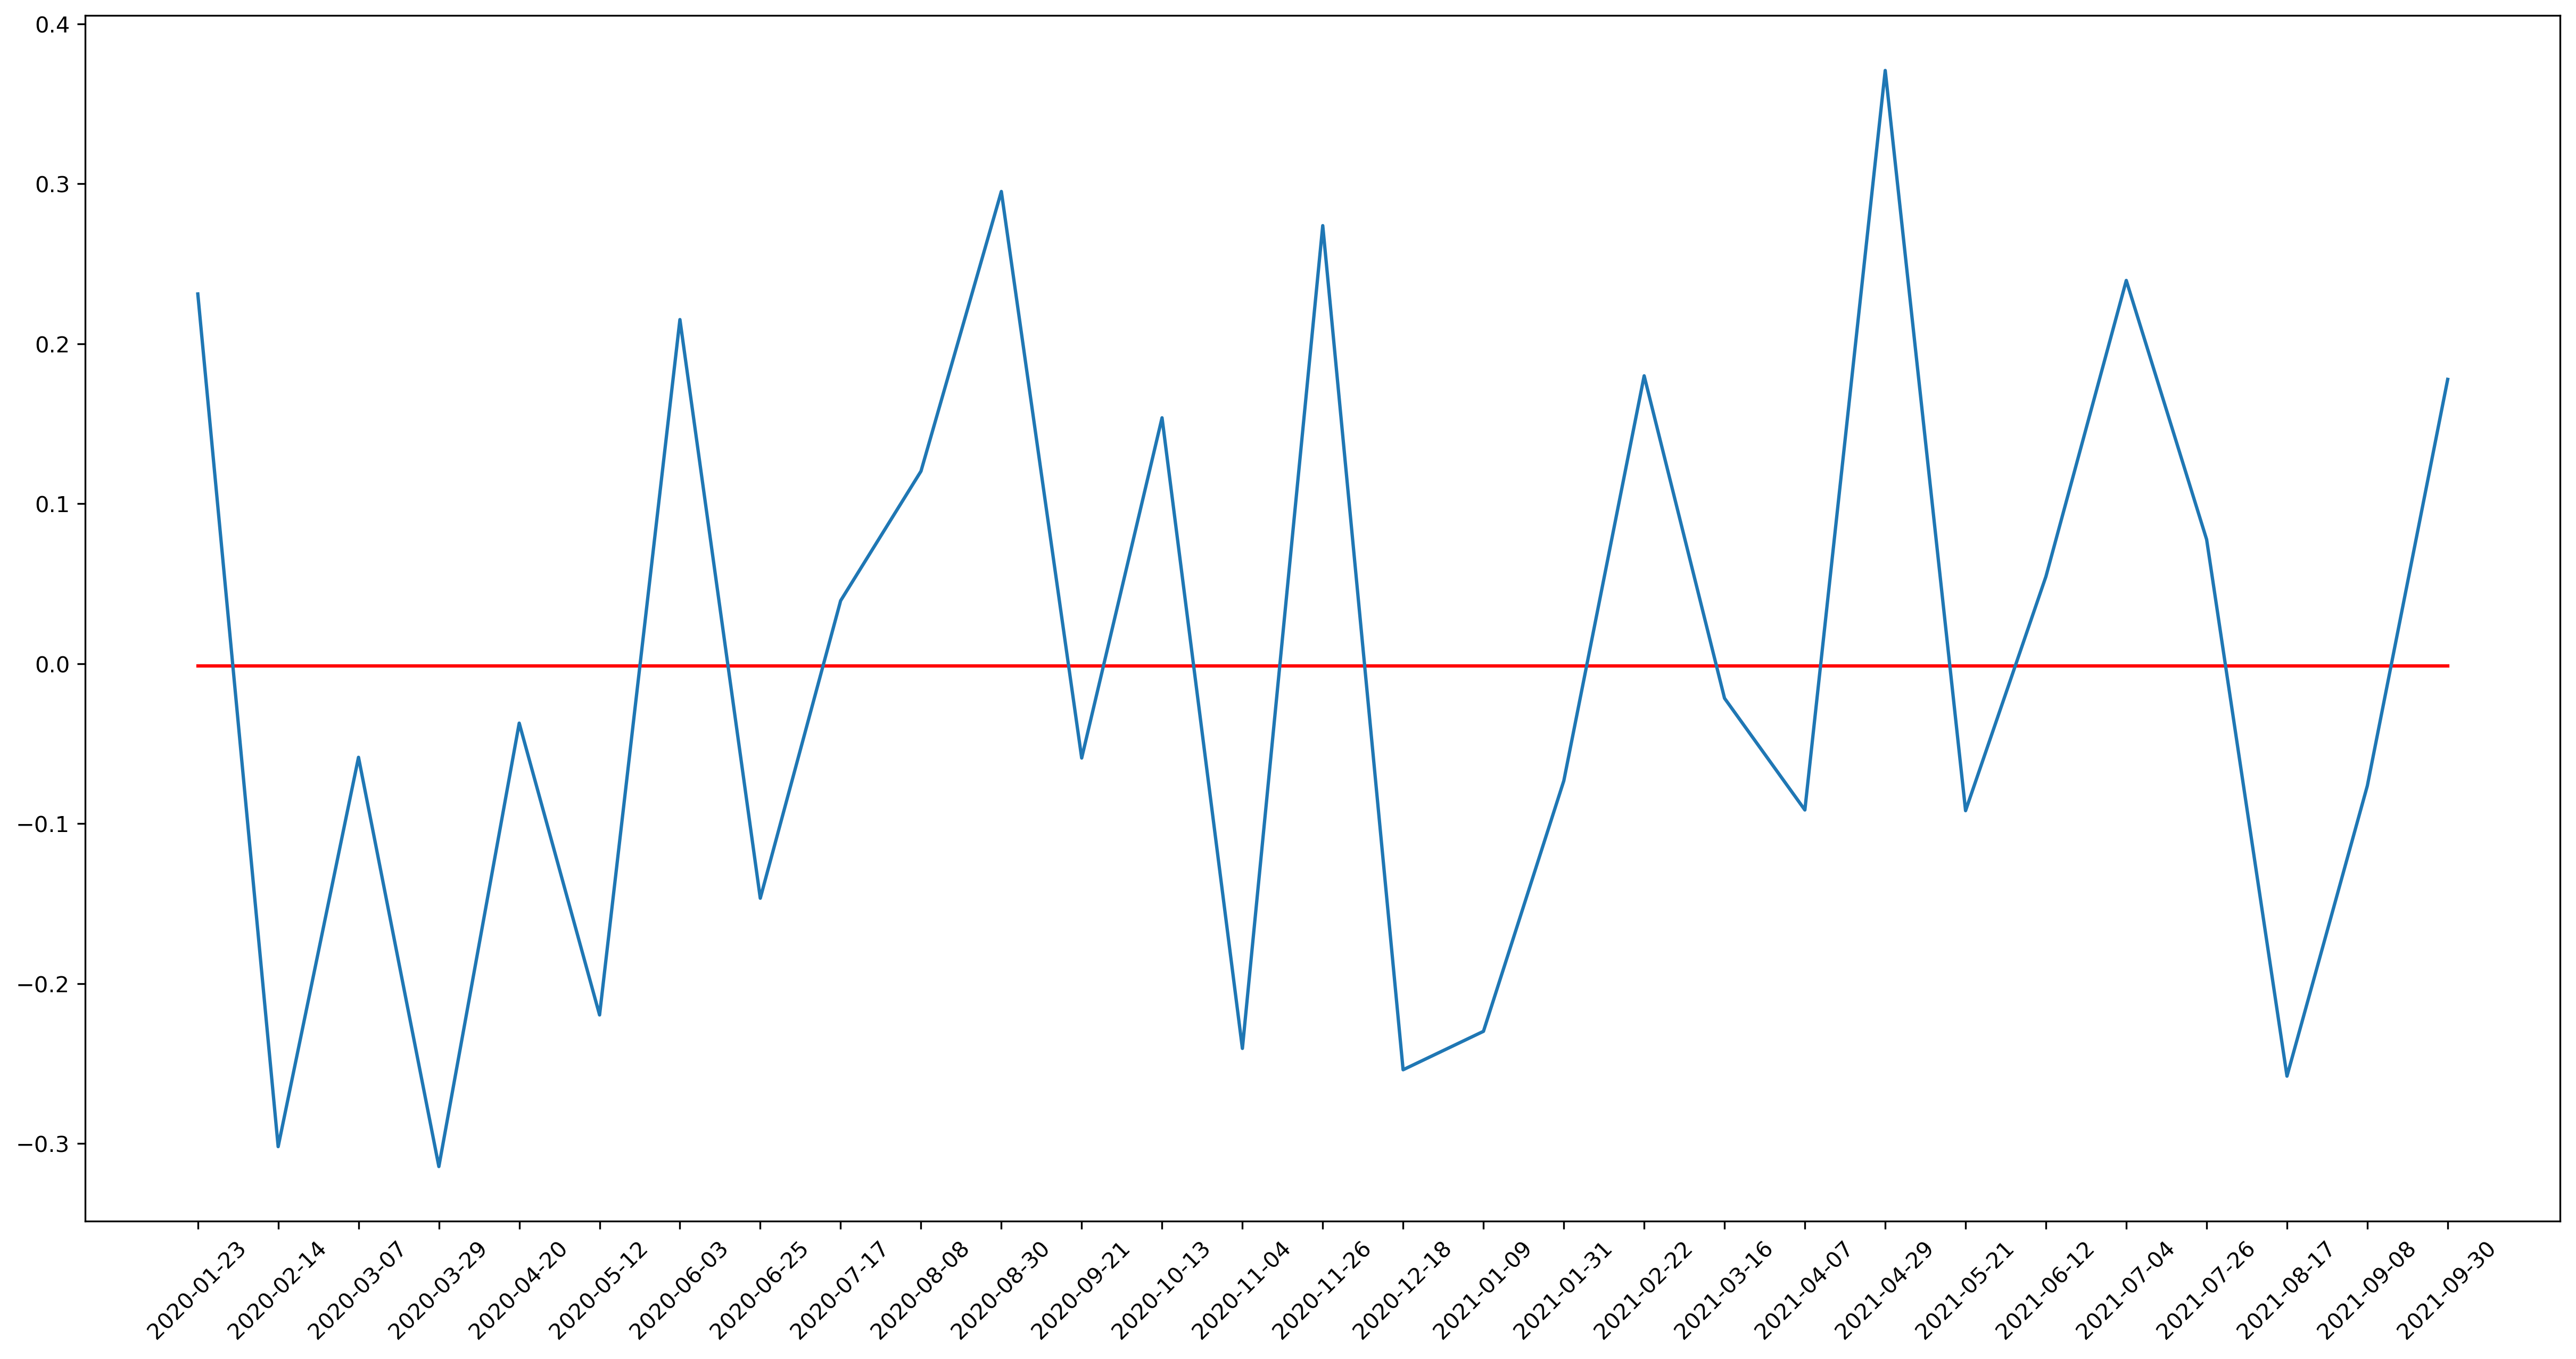

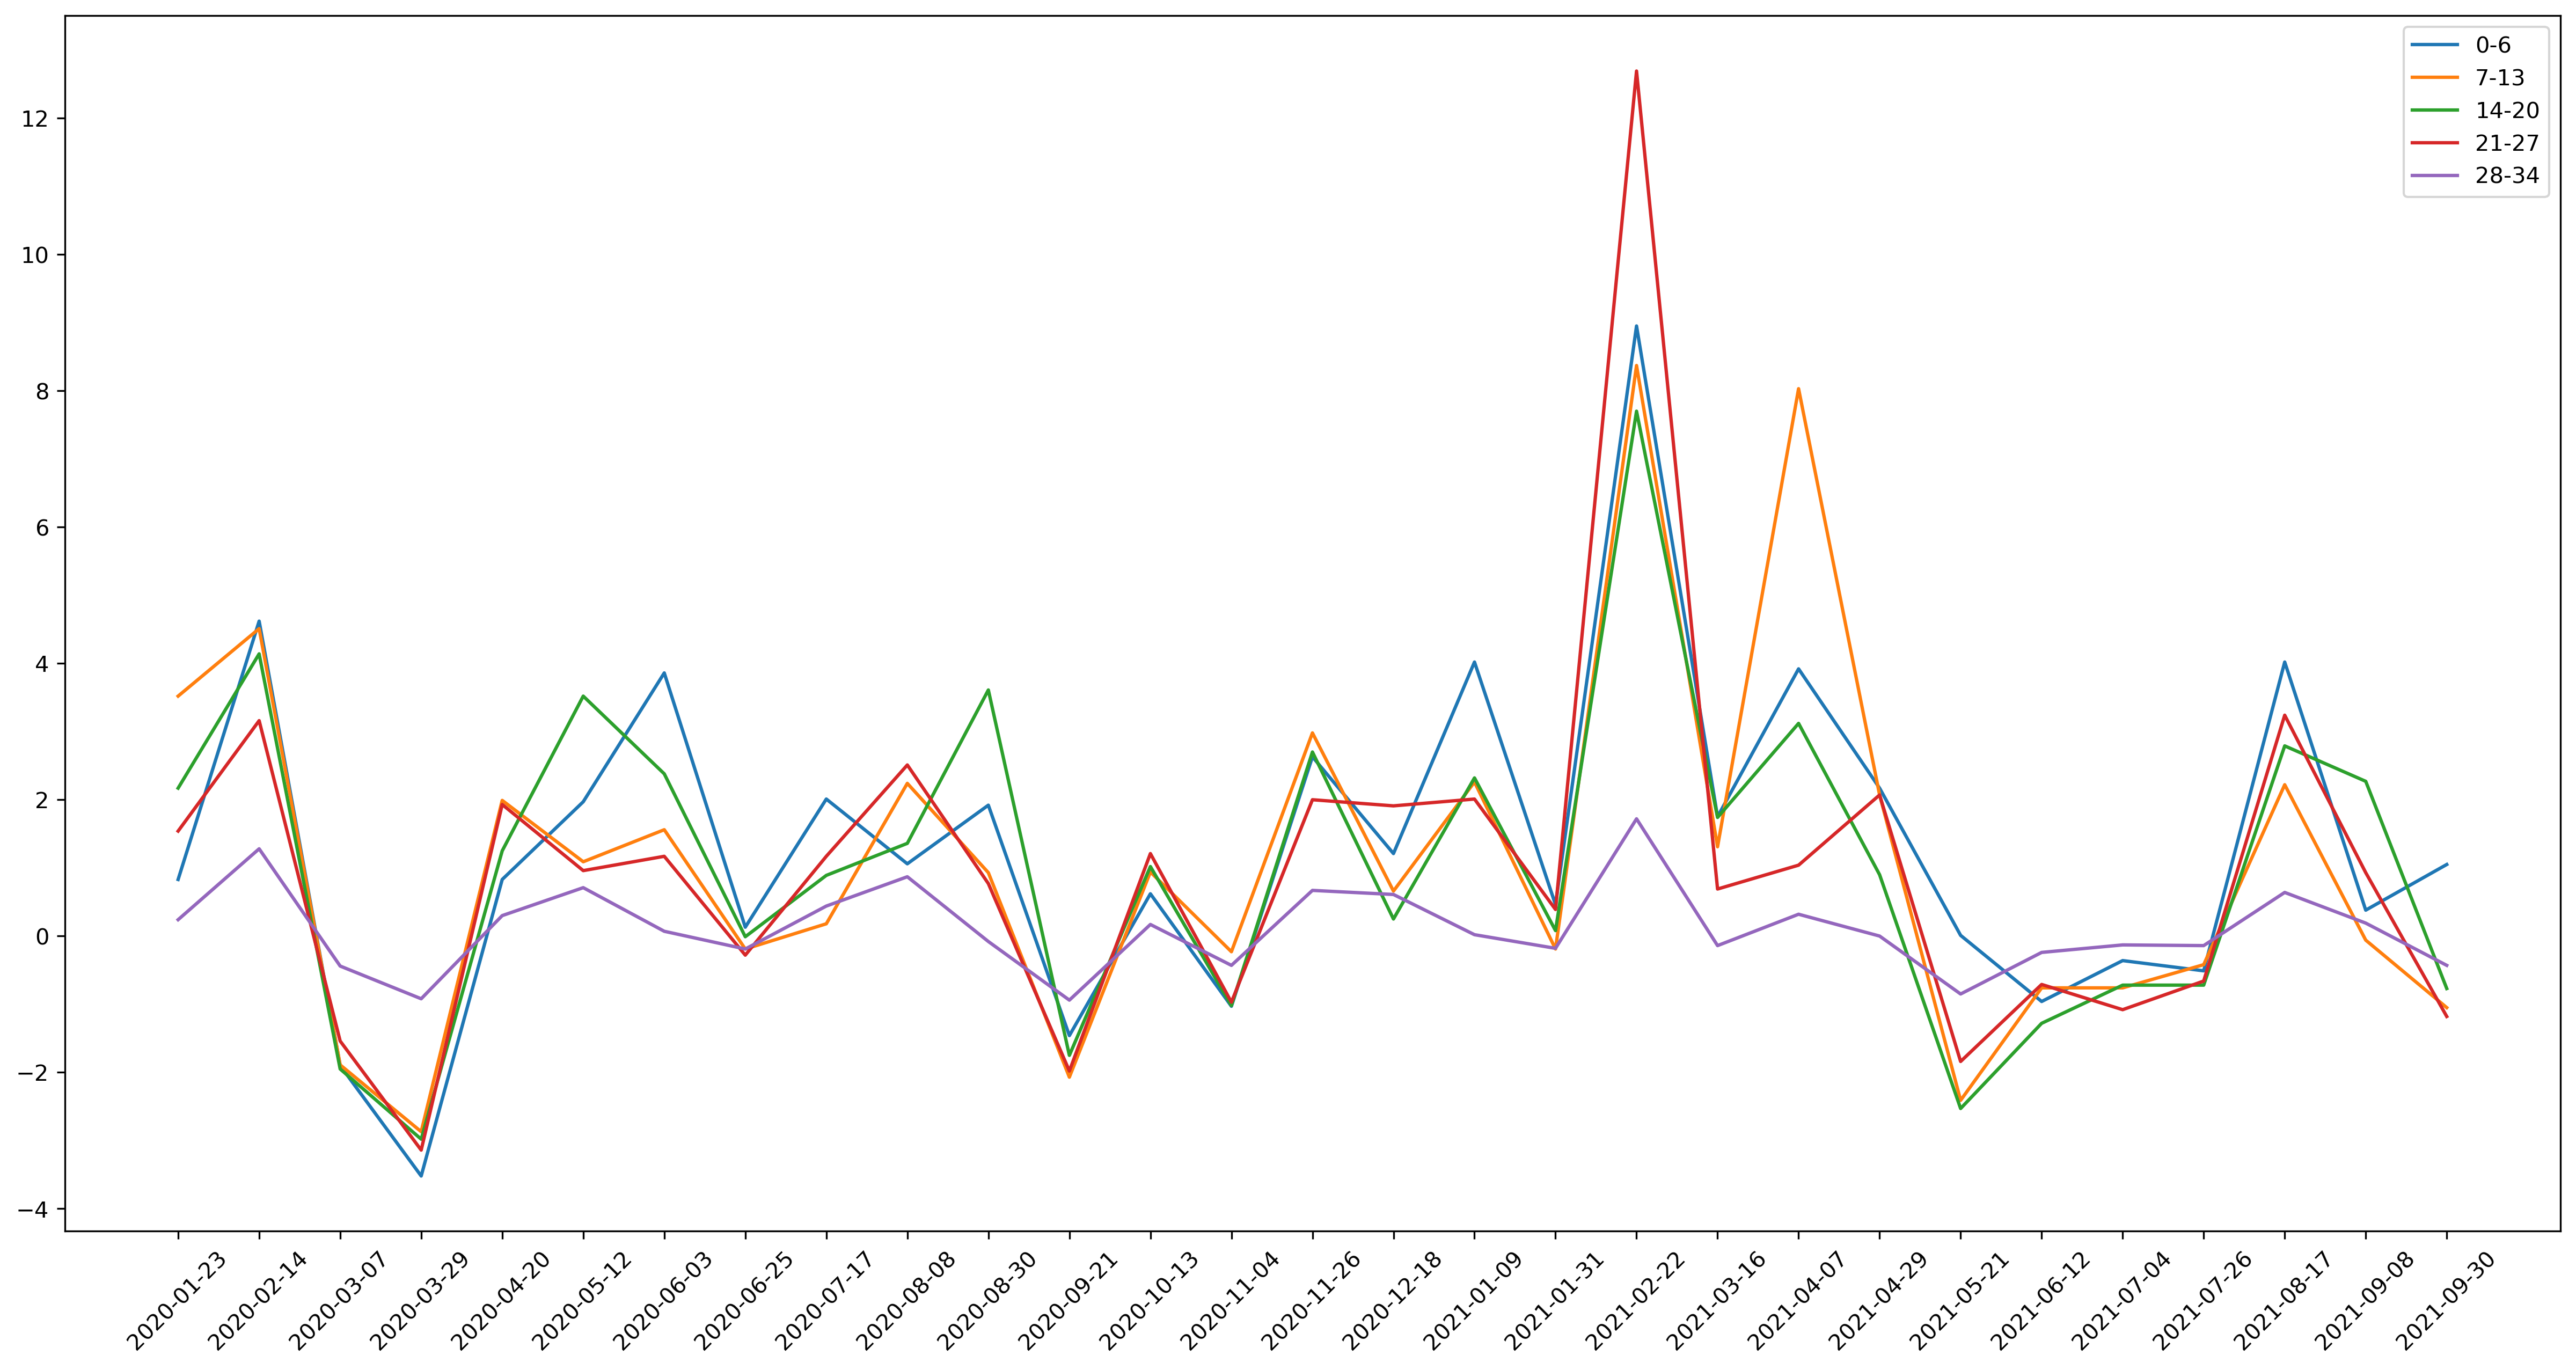

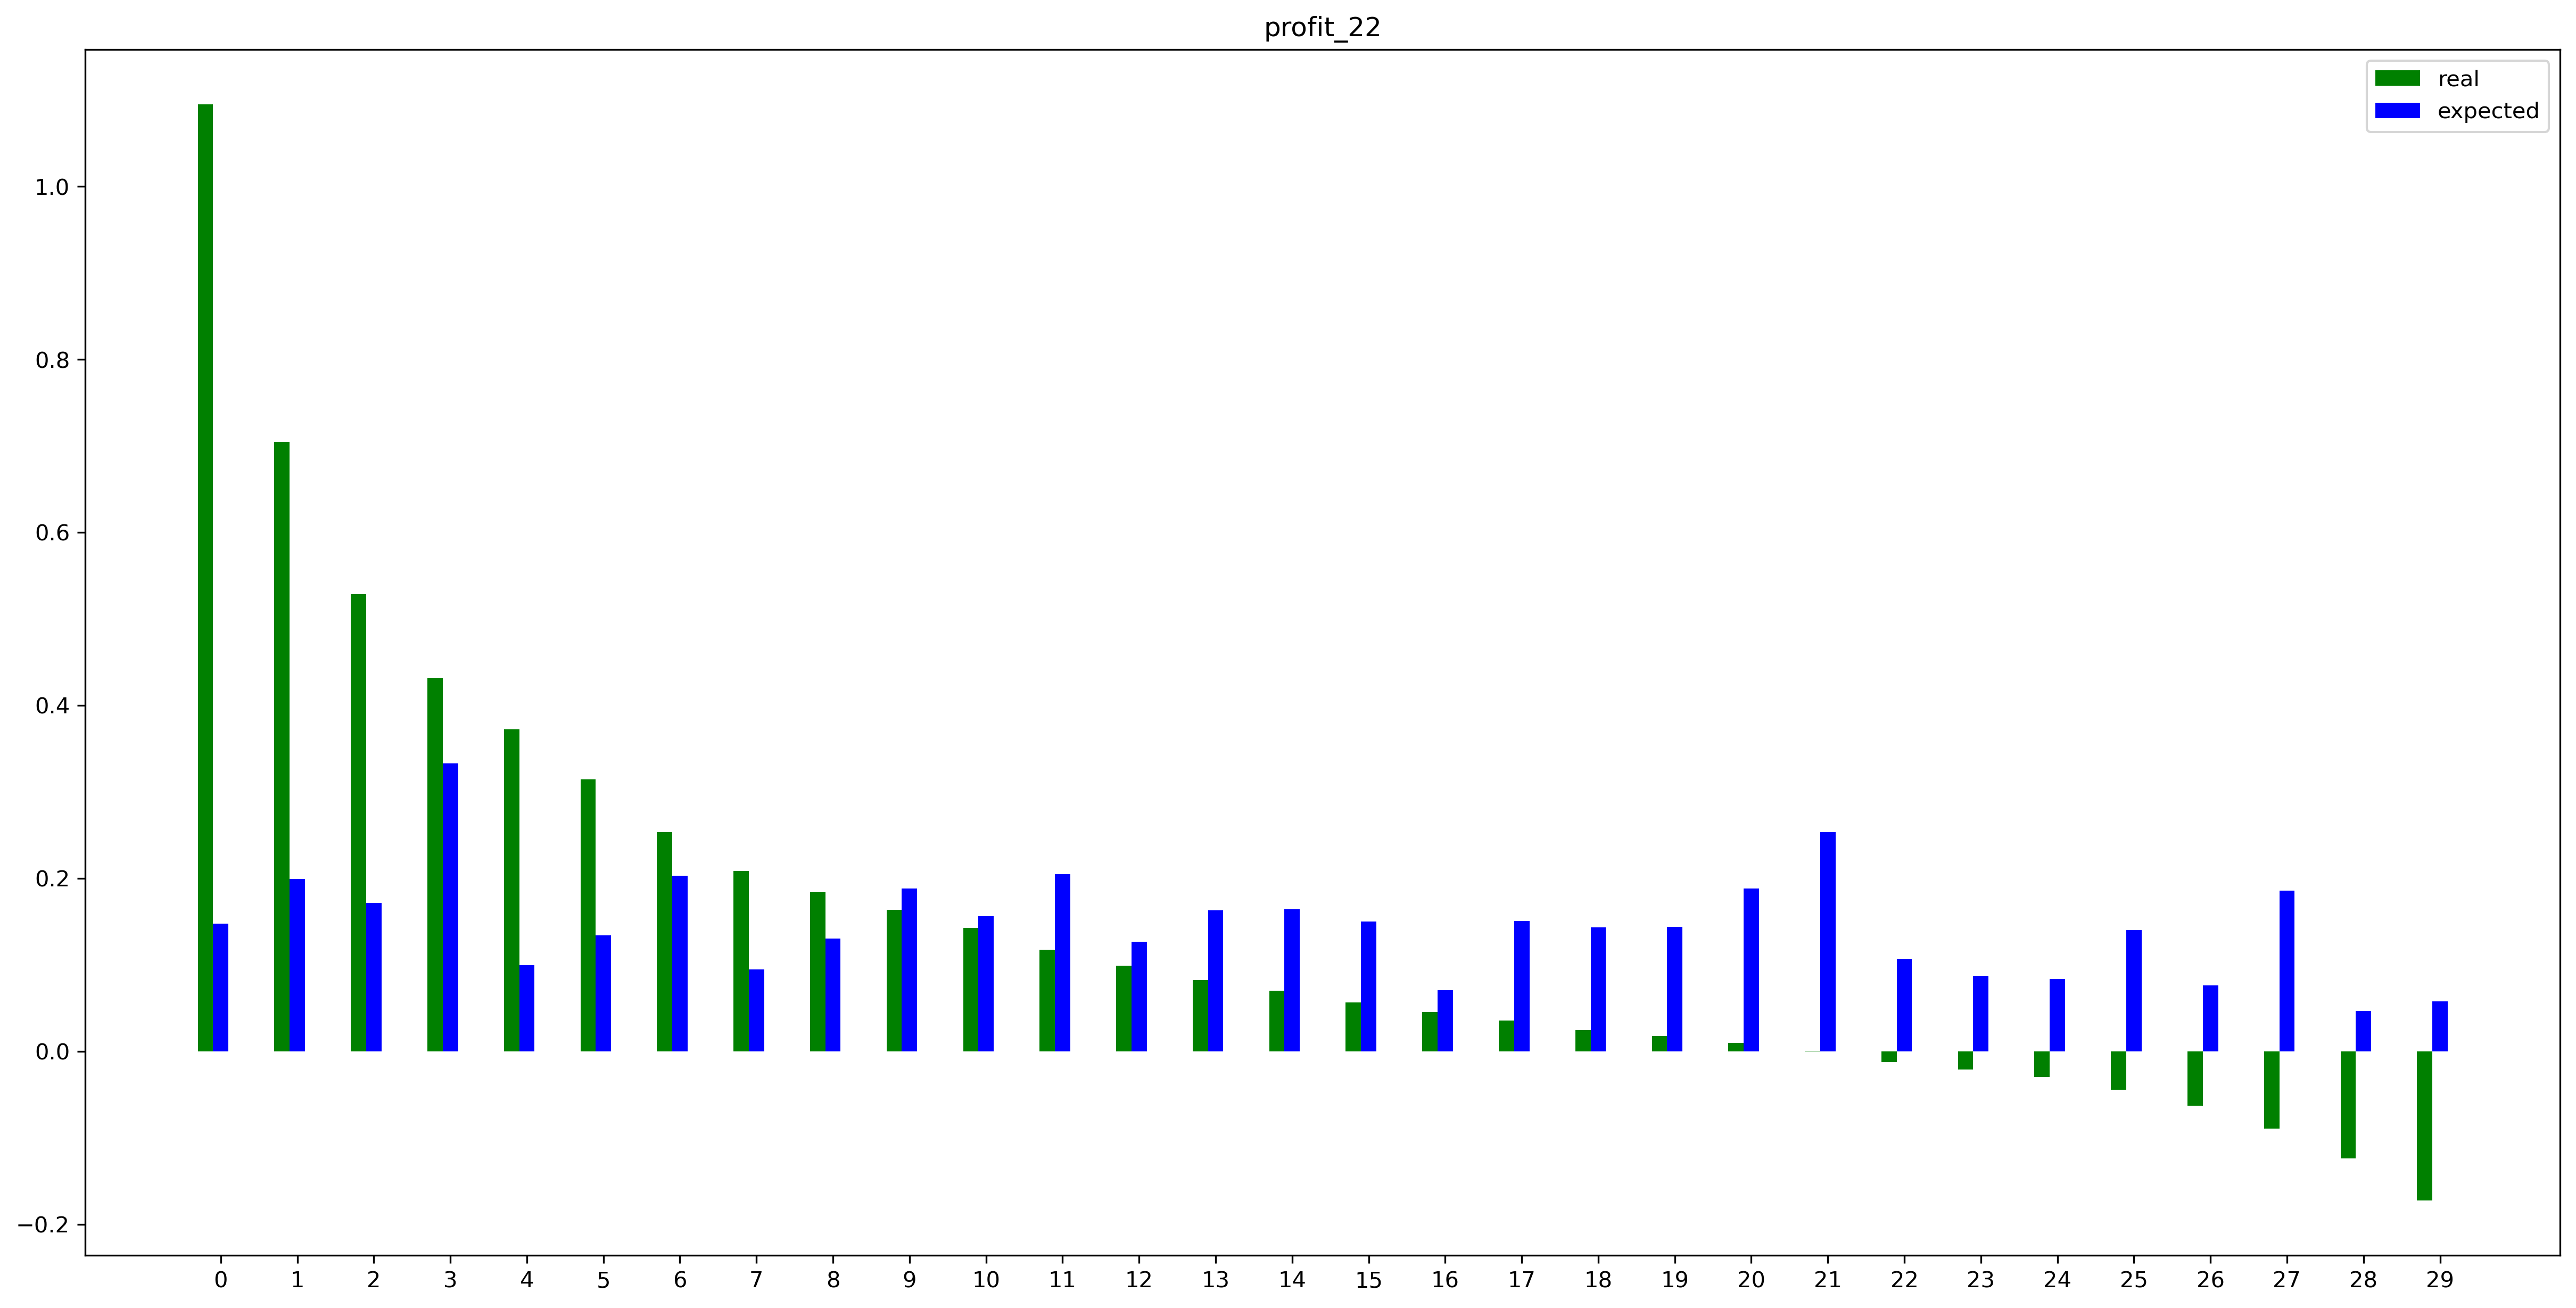

In [5]:
factor_list = conf['factor_list']
weight_list = conf['weight_list']
print(11224444)
factor_list =[(func.get_n_days_reverse, 3),(func.get_n_days_volatility, 10),(func.get_n_days_liquidity, 5),(func.BIAS_n_days, 5),(func.CCI_n_days, 5)
                   ] # 如果不用默认配置的factor修改这个即可
factor_profit('2020-01-01', '2021-10-01', datas, '1D', factor_list=factor_list, weight_list=weight_list, period=22,  #period是调仓周期
                  outdir=outdir, symbols=symbols, showplt=showplt, saveplt=saveplt, title='profit', group = 7)

### 皮尔逊相关系数

上面两个图分别是皮尔逊相关系数和预期收益，这里的相关系数是排名相关性，所以理论上我们希望每一期的排名都是强相关的。那意味着在因子分析的过程中，我们需要希望皮尔逊相关系数总体分布上更多的落在正数区间，越接近1越好。
从上面的结果来看，相关系数在零线上下两边的分布几乎是均等的，那意味着反转10这个因子在周期7的排名上是没有意义的。不过仅仅从这个角度，还不能说明这个因子不具备选股能力，因为如果在某一段排名上收益特别突出，其实也可以用来选股（币）。这种情况还没遇到，不过可以留意，假如3-5名上的因子收益在每一期总是非常好，那也可以做多排名这几位的币。因为反转因子在经济学意义上本身就很适用于选股。


### 分层回测

在这个模块中，我们会考察因子的收益，但更多的考察的是**不同因子之间的走线是否呈现彼此分离的单调上升，和走线的交叉情况**。

比如在上图，理想的情况是0-6的组合始终大于7-13的组合，7-13的组合始终大于14-20的组合...以此类推。

当然因为市场本身存在噪声和不确定性，可能很难完全符合预期。如果在**近期一段时间**各组走势能有显著性的分离，也能说明该因子可能在近期表现优异。

如果中间相邻两组之间走势时常有交叉现象，我们可以适当合并中间的分组，再进行分层回测，考量合并后的组能否区别于其他组

### 排名平均收益

**待增加分层每一期画图的改进：分3-5层，主要用于观察单调性和走线相互独立不交叉。开发建议上保留上面的功能，然后加一个图表展示分层回测（总币数/n为一个投资组合，展示收益。比如总池30，分3层，那排名top10一组，10-20一组，20-30一组。同一个canvas上回测画线，来展示效果，参数n作为传入变量，灵活修改），n通常不会大于5，不然线可能会缠绕交叉的很厉害**

在我们的profit模块功能中，按得分进行排名（模型会多前空后），实际收益则代表当期实际收益最高最低的币（做空实际收益最低的币会赚钱），排名平均收益反应了在每一期上排名x的币所取得的收益在全周期上的累计均值。

从图中分析可知，该因子收益和排名相关性不高，而且在后三位空单上表现差强人意

In [ ]:

# 矩阵相关性这块后续进一步研究或改进
# symbol_pearsonr('2020-01-01', '2021-10-08', '7D', datas, '1D', factor_list=factor_list, outdir=outdir,
#                 symbols=symbols, showplt=showplt, saveplt=saveplt)

# calculate_pearsonr('2020-01-01','2021-07-10','7D',datas,'1D',factor_list=factor_list,outdir=outdir,symbols=symbols,showplt=showplt,saveplt=saveplt)
# ic_rankr('20210105', '20210630', '3D', datas, '1D', symbols=symbols)
ic_rank('20210105', '20210630', '3D', datas, '1D') 

IC反应了因子的预测能力，原则上当然是越大越好。不过从分布来看，该因子整体呈现噪声分布，表现是不佳的。

### 

### 比照
在上述表现中，func.get_n_days_reverse, 10 的效果并不好。数字货币的周期通常相对更短，修改更短的回溯周期3天，func.get_n_days_reverse, 3 并用更长的调仓周期，可见在2020年中，其排名相关性显著提升，相较于之前的因子，收益更佳

111222
234123
234123
124124
OMGUSDT list index out of range
124124
THETAUSDT list index out of range
124124
BATUSDT list index out of range
124124
WAVESUSDT list index out of range
124124
IOTAUSDT list index out of range
124124
XMRUSDT list index out of range
124124
BTTUSDT list index out of range
124124
ONTUSDT list index out of range
124124
NEOUSDT list index out of range
124124
XRPUSDT list index out of range
124124
EOSUSDT list index out of range
124124
LTCUSDT list index out of range
124124
ETHUSDT list index out of range
124124
BNBUSDT list index out of range
124124
BTCUSDT list index out of range
124124
XLMUSDT list index out of range
124124
TRXUSDT list index out of range
124124
DASHUSDT list index out of range
124124
ZECUSDT list index out of range
124124
ETCUSDT list index out of range
124124
LINKUSDT list index out of range
124124
QTUMUSDT list index out of range
124124
VETUSDT list index out of range
124124
MATICUSDT list index out of range
124124
IOSTUSDT list index out of

Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dat

124124
MATICUSDT list index out of range
124124
IOSTUSDT list index out of range
124124
QTUMUSDT list index out of range
124124
WAVESUSDT list index out of range
124124
ICXUSDT list index out of range
124124
VETUSDT list index out of range
124124
ONTUSDT list index out of range
124124
NEOUSDT list index out of range
124124
TRXUSDT list index out of range
124124
XLMUSDT list index out of range
124124
LINKUSDT list index out of range
124124
ETCUSDT list index out of range
124124
BNBUSDT list index out of range
124124
EOSUSDT list index out of range
124124
BTCUSDT list index out of range
124124
LTCUSDT list index out of range
124124
ETHUSDT list index out of range
124124
XRPUSDT list index out of range
124124
ZECUSDT list index out of range
124124
HOTUSDT list index out of range
124124
BTTUSDT list index out of range
124124
DASHUSDT list index out of range
124124
XMRUSDT list index out of range
234123
124124
BTCUSDT list index out of range
124124
ETHUSDT list index out of range
124124
XRP

  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex]

124124
NEOUSDT list index out of range
124124
TRXUSDT list index out of range
124124
BTCUSDT list index out of range
124124
ETHUSDT list index out of range
124124
ETCUSDT list index out of range
124124
XRPUSDT list index out of range
124124
LTCUSDT list index out of range
124124
BNBUSDT list index out of range
124124
LINKUSDT list index out of range
124124
EOSUSDT list index out of range
124124
XLMUSDT list index out of range
124124
VETUSDT list index out of range
124124
QTUMUSDT list index out of range
124124
DASHUSDT list index out of range
124124
XMRUSDT list index out of range
124124
IOSTUSDT list index out of range
124124
IOTAUSDT list index out of range
124124
ZECUSDT list index out of range
124124
ONTUSDT list index out of range
124124
BATUSDT list index out of range
124124
ZRXUSDT list index out of range
124124
WAVESUSDT list index out of range
124124
ICXUSDT list index out of range
124124
OMGUSDT list index out of range
234123
124124
CELRUSDT list index out of range
124124
OMG

Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dat

124124
ETHUSDT list index out of range
124124
XRPUSDT list index out of range
124124
DASHUSDT list index out of range
124124
LTCUSDT list index out of range
124124
EOSUSDT list index out of range
124124
TRXUSDT list index out of range
124124
ETCUSDT list index out of range
124124
ZRXUSDT list index out of range
124124
ICXUSDT list index out of range
124124
IOTAUSDT list index out of range
124124
ZILUSDT list index out of range
124124
IOSTUSDT list index out of range
124124
OMGUSDT list index out of range
124124
BTTUSDT list index out of range
124124
HOTUSDT list index out of range
124124
CELRUSDT list index out of range
234123
124124
CELRUSDT list index out of range
124124
IOTAUSDT list index out of range
124124
BTTUSDT list index out of range
124124
OMGUSDT list index out of range
124124
THETAUSDT list index out of range
124124
WAVESUSDT list index out of range
124124
IOSTUSDT list index out of range
124124
DASHUSDT list index out of range
124124
XMRUSDT list index out of range
124124

  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex]

124124
BTTUSDT list index out of range
124124
ETCUSDT list index out of range
124124
VETUSDT list index out of range
124124
NEOUSDT list index out of range
124124
QTUMUSDT list index out of range
124124
ONTUSDT list index out of range
124124
IOTAUSDT list index out of range
124124
MATICUSDT list index out of range
124124
OMGUSDT list index out of range
124124
BATUSDT list index out of range
124124
ICXUSDT list index out of range
124124
WAVESUSDT list index out of range
124124
ZRXUSDT list index out of range
124124
HOTUSDT list index out of range
124124
CELRUSDT list index out of range
234123
124124
CELRUSDT list index out of range
124124
ZRXUSDT list index out of range
124124
WAVESUSDT list index out of range
124124
DASHUSDT list index out of range
124124
XMRUSDT list index out of range
124124
ETCUSDT list index out of range
124124
ZECUSDT list index out of range
124124
IOTAUSDT list index out of range
124124
LTCUSDT list index out of range
124124
THETAUSDT list index out of range
1241

  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex]

124124
ONTUSDT list index out of range
124124
XLMUSDT list index out of range
124124
IOTAUSDT list index out of range
124124
NEOUSDT list index out of range
124124
WAVESUSDT list index out of range
124124
BTTUSDT list index out of range
124124
QTUMUSDT list index out of range
124124
OMGUSDT list index out of range
124124
BATUSDT list index out of range
124124
ZRXUSDT list index out of range
124124
CELRUSDT list index out of range
234123
124124
CELRUSDT list index out of range
124124
MATICUSDT list index out of range
124124
HOTUSDT list index out of range
124124
ICXUSDT list index out of range
124124
QTUMUSDT list index out of range
124124
ZRXUSDT list index out of range
124124
BATUSDT list index out of range
124124
IOTAUSDT list index out of range
124124
BTTUSDT list index out of range
124124
ONTUSDT list index out of range
124124
OMGUSDT list index out of range
124124
ETCUSDT list index out of range
124124
NEOUSDT list index out of range
124124
ZECUSDT list index out of range
124124
V

Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dat


LTCUSDT list index out of range
124124
MATICUSDT list index out of range
124124
IOSTUSDT list index out of range
124124
ICXUSDT list index out of range
234123
124124
CELRUSDT list index out of range
124124
THETAUSDT list index out of range
124124
IOTAUSDT list index out of range
124124
QTUMUSDT list index out of range
124124
VETUSDT list index out of range
124124
BTTUSDT list index out of range
124124
ONTUSDT list index out of range
124124
XRPUSDT list index out of range
124124
BTCUSDT list index out of range
124124
BNBUSDT list index out of range
124124
ETHUSDT list index out of range
124124
TRXUSDT list index out of range
124124
LTCUSDT list index out of range
124124
EOSUSDT list index out of range
124124
HOTUSDT list index out of range
124124
XLMUSDT list index out of range
124124
LINKUSDT list index out of range
124124
IOSTUSDT list index out of range
124124
ICXUSDT list index out of range
124124
WAVESUSDT list index out of range
124124
NEOUSDT list index out of range
124124
ZILUS

IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-52-1cfb1fee430b>", line 236, in factor_profit
    g

124124
EOSUSDT list index out of range
124124
ZILUSDT list index out of range
124124
IOSTUSDT list index out of range
124124
BTTUSDT list index out of range
124124
NEOUSDT list index out of range
124124
ZECUSDT list index out of range
124124
ONTUSDT list index out of range
124124
ICXUSDT list index out of range
124124
DASHUSDT list index out of range
124124
CELRUSDT list index out of range
124124
BATUSDT list index out of range
124124
OMGUSDT list index out of range
124124
QTUMUSDT list index out of range
124124
ZRXUSDT list index out of range
234123
124124
CELRUSDT list index out of range
124124
ICXUSDT list index out of range
124124
WAVESUSDT list index out of range
124124
XMRUSDT list index out of range
124124
ZECUSDT list index out of range
124124
OMGUSDT list index out of range
124124
ZILUSDT list index out of range
124124
NEOUSDT list index out of range
124124
IOTAUSDT list index out of range
124124
THETAUSDT list index out of range
124124
BATUSDT list index out of range
124124
L

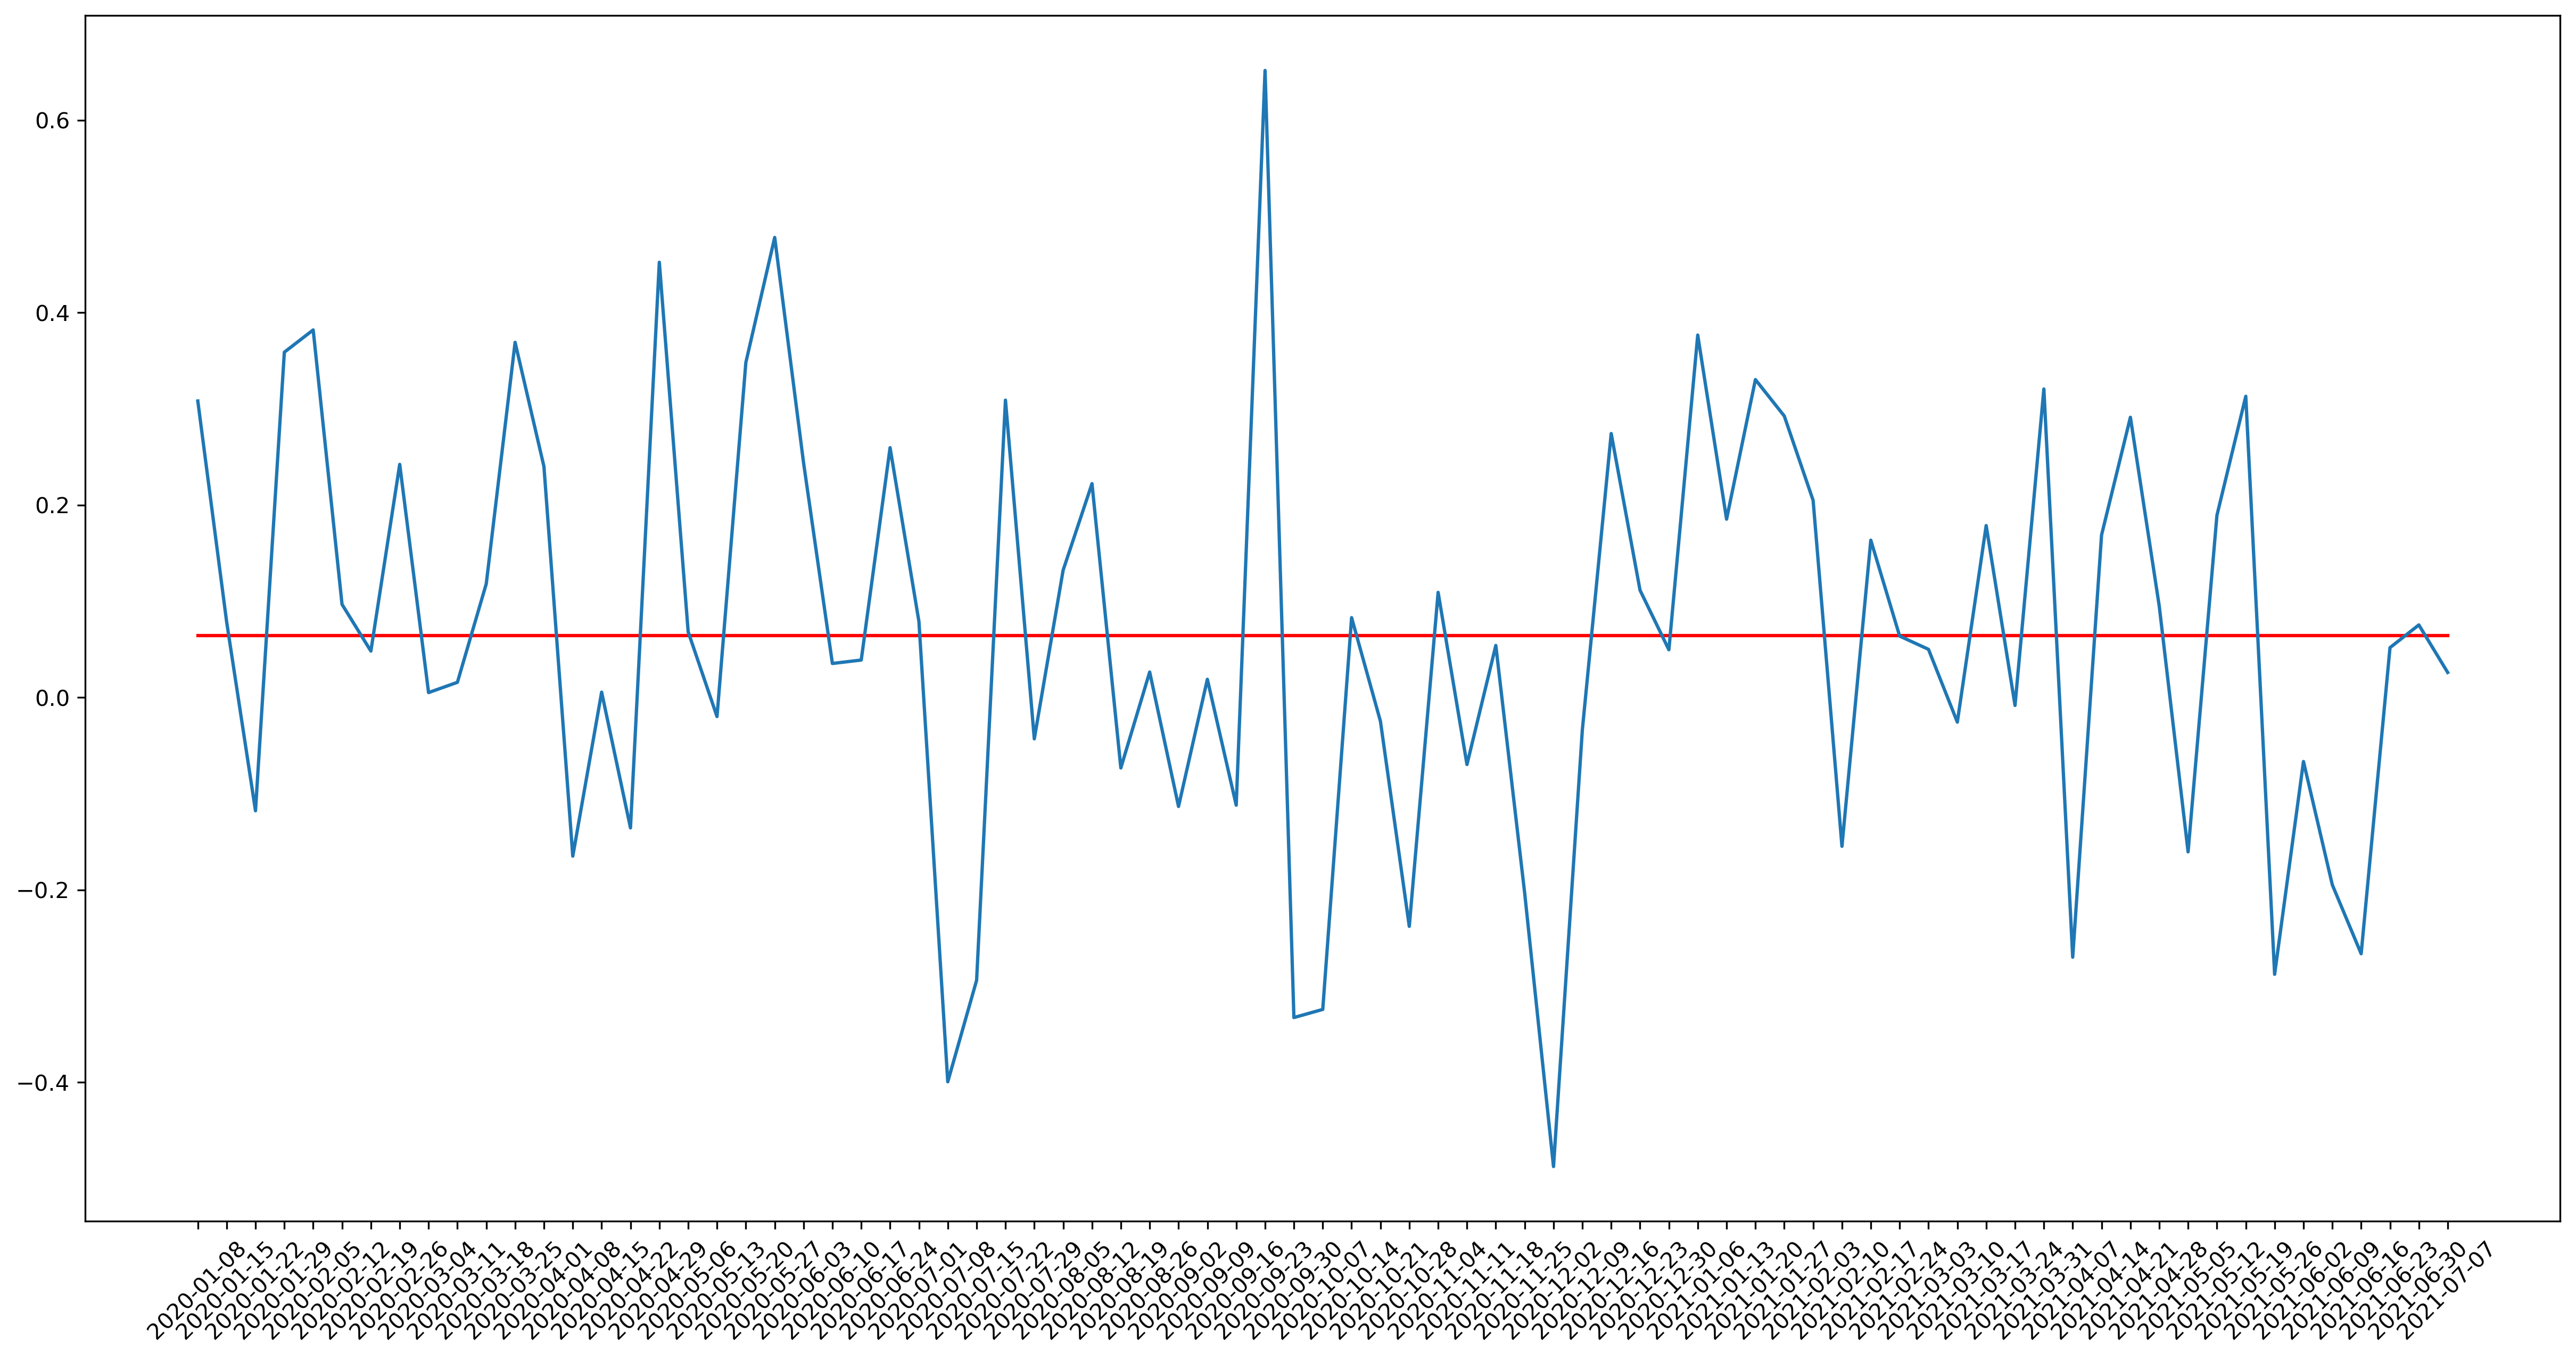

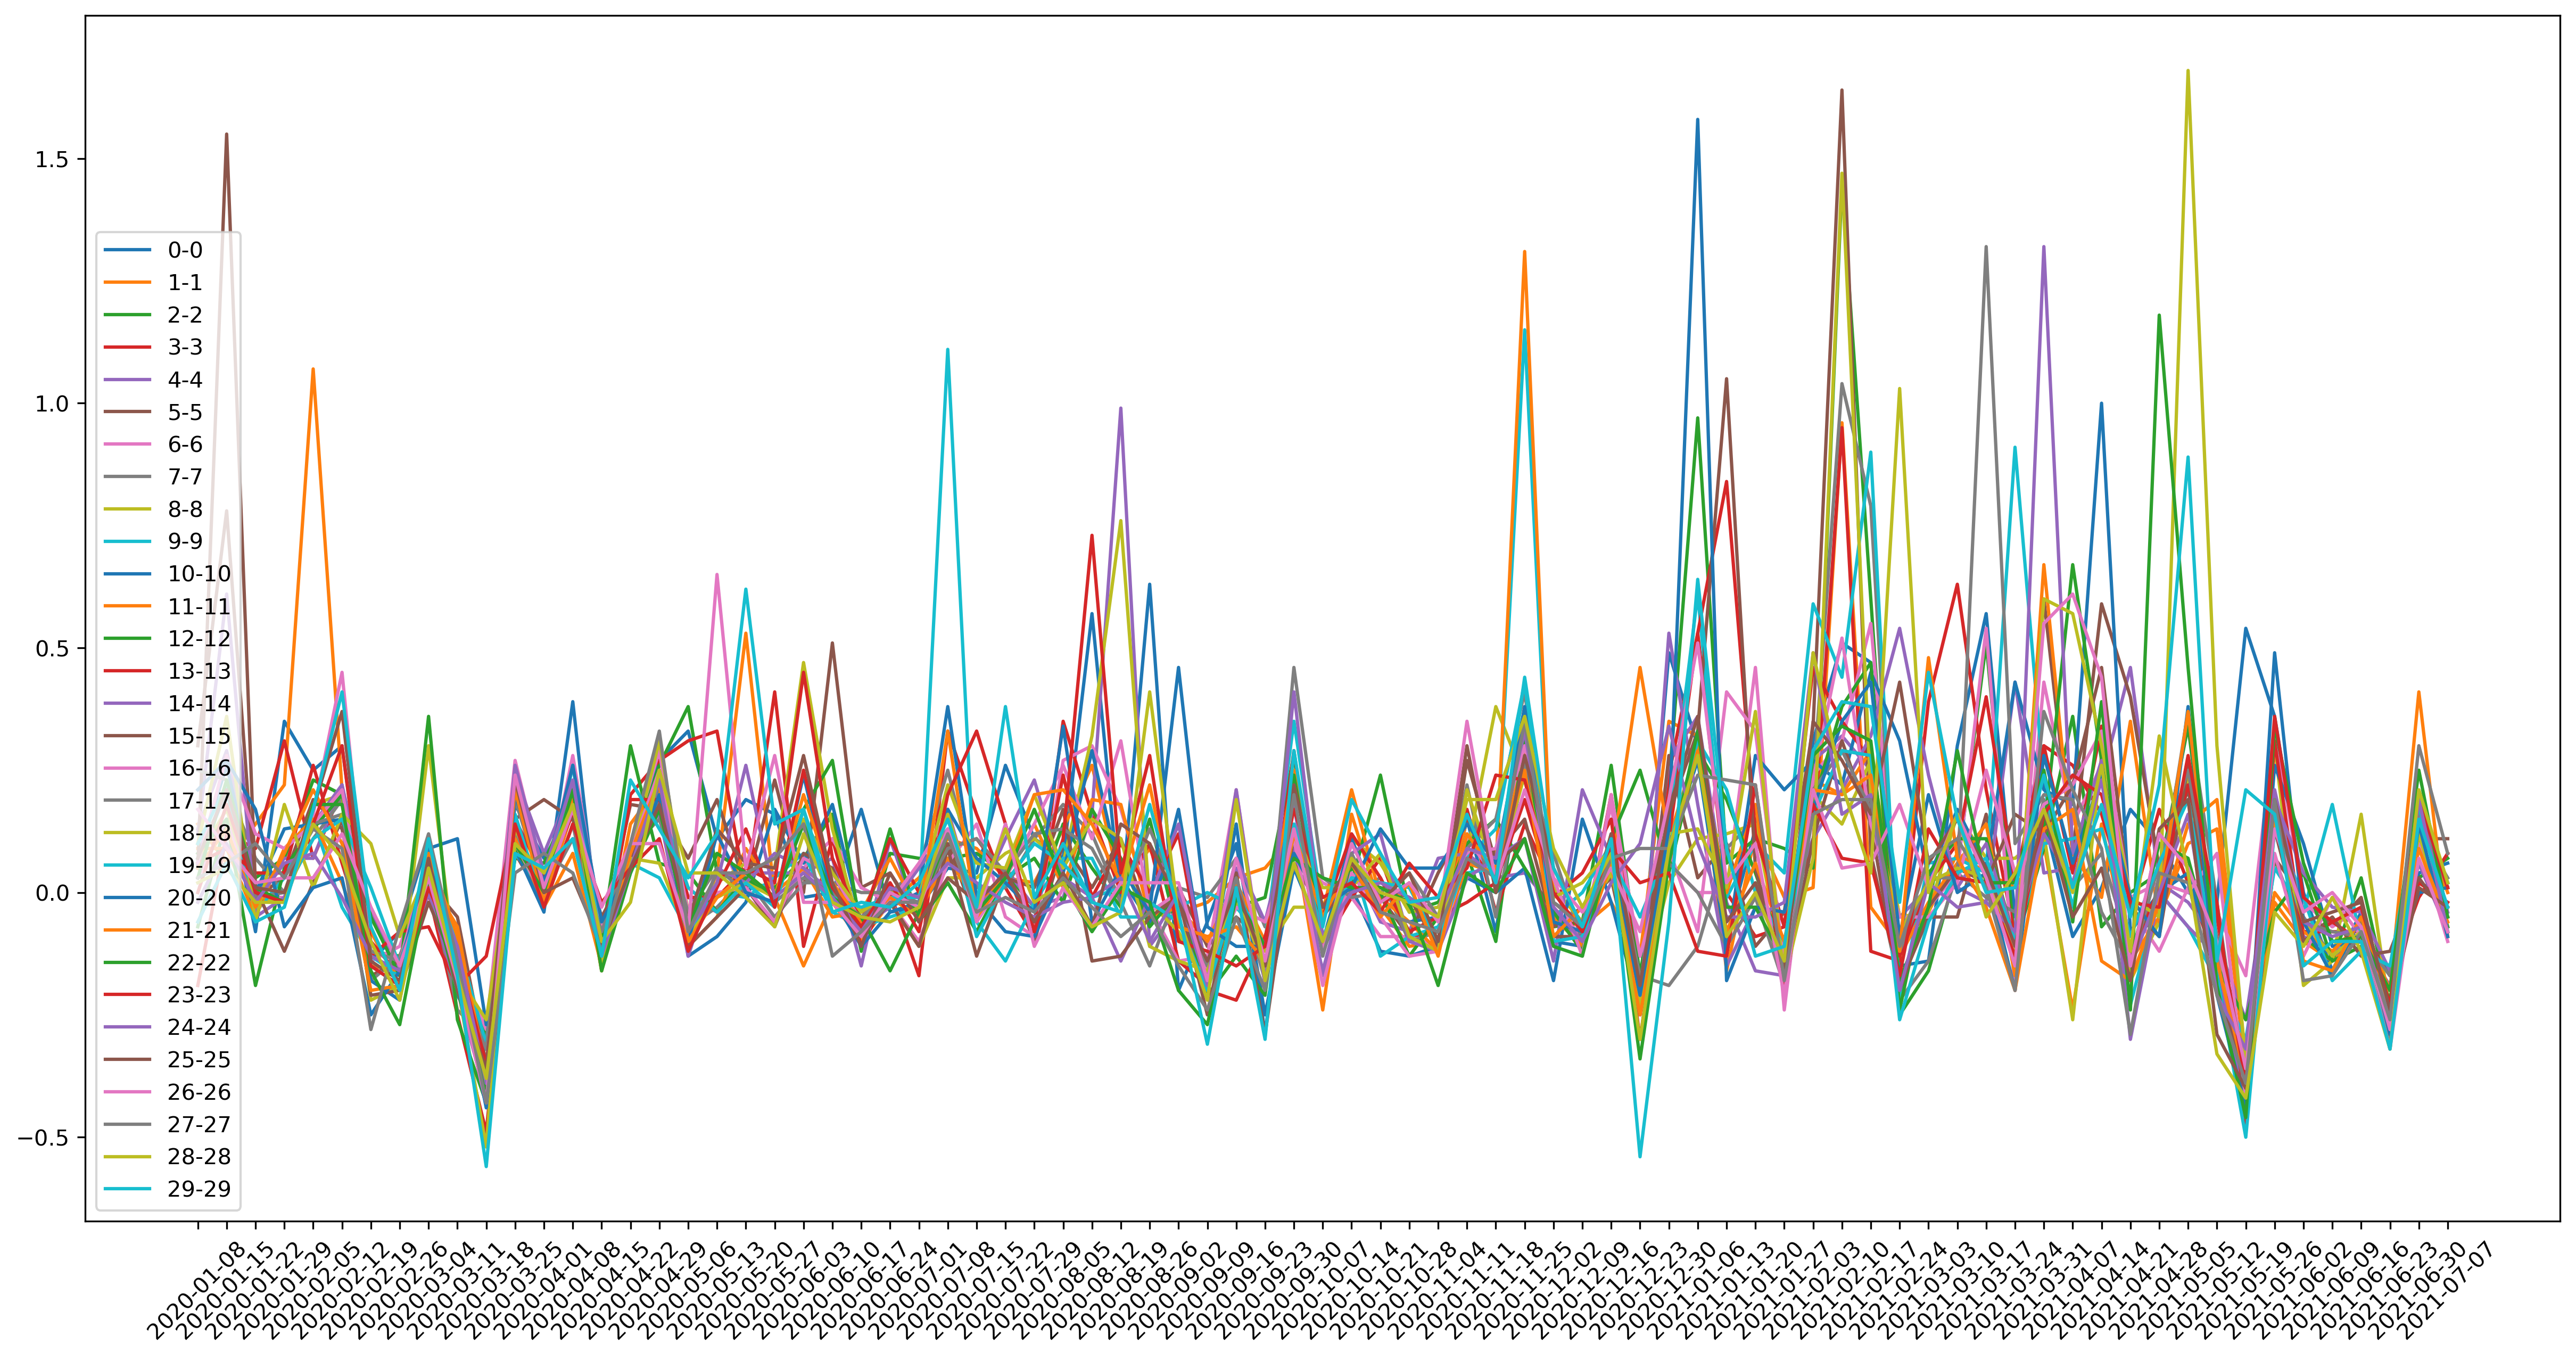

ValueError: x and y must have same first dimension, but have shapes (79,) and (0,)

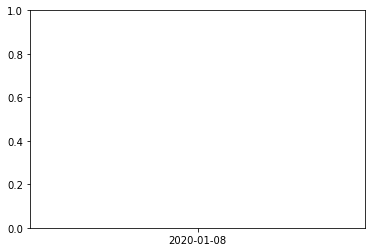

In [62]:
factor_list2 =[(func.get_n_days_liquidity, 5)
                   ]
weight_list2 = [1]
factor_profit('2020-01-01', '2021-07-10', datas, '1D', factor_list=factor_list2, weight_list=weight_list2, period=7,
                  outdir=outdir, symbols=symbols, showplt=showplt, saveplt=saveplt, title='profit')

In [ ]:
ic_rank('20210105', '20210630', '3D', datas, '1D') 

从因子ic来看，相较于上图，中间的波动减少了，说明修改后的因子稳定性更强，但预测能力仍然不显著。也许在短周期上会有效果。IC评估并不绝对，很多技术面因子都呈现噪声形态，但依然可以通过比较IC形态来迭代更优因子。不过优秀的因子IC会形成“单边形态”，IC的均值线显著大于0或者1（后续做成柱状图展示会更容易判断）

In [ ]:
# bootstrap r-square

### bootstrap显著性检验



#### 资产数据应用moving block bootstrap抽样
首先选取一个长度为n的目标序列，选择长度b作为分割长度的序列(即每次抽取序列的长度)
将原序列(长度为n的序列)尽可能多的分割成长度为b的重叠的(overlaping)子序列，总共可以分割成n-b+1个重叠子序列。
由于每个序列长度为b，总共仅需n/b个序列即可组成与原序列等长的序列。因而在总共n-b+1个序列中随机抽取n/b个序列。
最后，再将抽出来的n/b个序列按照其抽样顺序重新组合，即可得到bootstrap序列。

1. 通过获取投组收益率和因子值，通过数据处理组合出初始样本
2. 对每组投资组合的原始样本进行boostrap
3. 用原始样本中的因子值和投资组合收益进行回归，每组取截距，然后用所有组合截距的最小值test_statistic代表定价错误率
4. 基于boostrap样本做3中同样的操作，将所有的test_statistic作为分布。计算分布的5%进行因子显著性检验
5. 如果原始样本的test_statistic小于boostrap test_statistic 的5%分位数置信阈值，那么我们认为该因子在该样本上是显著的

因子资产定价错误率 [0.01361502] bootstrap样本上的5%置信区间上的阈值 0.013987489251432297


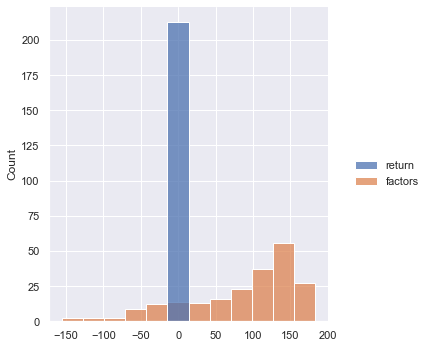

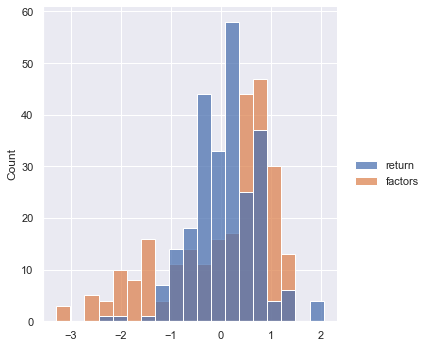

In [65]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import random

factor_list =[(func.get_n_days_reverse, 3),(func.get_n_days_volatility, 10),(func.get_n_days_liquidity, 5),(func.BIAS_n_days, 5),(func.CCI_n_days, 5)
                   ] # 如果不用默认配置的factor修改这个即可


def boostrap_2_value(startdate, enddate, datas, datafreq, factor_list, weight_list, period=7, group=1, block_size = 3):

    def get_value_matrix(datas, end_date, data_freq, factor_list, weight_list):
        dics = {}
        for symbol in symbols:
            data = datas[symbol]
            fvalues = []
            for findex in range(len(factor_list)):
                f = factor_list[findex][0]
                if f == func.get_market_caps:
                    fvalues.append(f(data, end_date, matrix=True) * weight_list[findex])
                else:
                    days = factor_list[findex][1]
                    fval = f(data, end_date, days, data_freq, matrix=True)
                    fvalues.append(fval * weight_list[findex])
            dics[symbol] = sum(fvalues)[startdate:end_date]
        return dics
    def get_list_order(factor_values): 
        x = np.array(factor_values)
        a = np.argsort(-x, axis=1)  # 降序index
        a = pd.DataFrame(a)
        a['trade_date'] = factor_values[0].index
        a = a.set_index(['trade_date'])
        return a
    symbol_length = len(symbols)
    factor_values = get_value_matrix(datas[datafreq], None, datafreq, factor_list, weight_list)
    factor_values = pd.concat(factor_values, axis=1)
    factor_values.columns = range(symbol_length)
    factor_order = get_list_order(factor_values)
    factor_order.columns = range(symbol_length)
    close_profit = {}
    close = {}
    date_ranges = pd.date_range(startdate, enddate, freq=(str(period) + datafreq[-1]))
    for symbol in symbols:
        data = datas[datafreq][symbol]
        close_profit[symbol] = data['Close'] - data['Close'].shift(period)
        close[symbol] = data['Close']
    real_profits = [0] * symbol_length
    expect_profits = [0] * symbol_length
    lastdate = None
    dates = []
    groupdatas = []
    groupfactorvalues=[]
    try:
        for currentdate in date_ranges:
            if lastdate is None:
                lastdate = currentdate
                continue
            current = []
            expectsort = []
            for i in range(symbol_length):
                try:
                    symbol = symbols[i]
                    current.append(1 / close[symbol][lastdate] * close_profit[symbol][currentdate])
                except Exception as e:
                    print(symbol, e)
            current.sort()
            for i in range(symbol_length):
                try:
                    expectsort.append(factor_order[i][lastdate])
                    symbol = symbols[factor_order[i][lastdate]]
                    expect_profits[i] = expect_profits[i] + 1 / close[symbol][lastdate] * close_profit[symbol][
                        currentdate]
                    real_profits[i] = real_profits[i] + current[symbol_length - i - 1]
                    groupindex = int(i / group)
                    if groupindex >= len(groupdatas):
                        groupdatas.append([])
                        groupfactorvalues.append([])
                    if len(dates) >= len(groupdatas[groupindex]):
                        groupdatas[groupindex].append(0)
                        groupfactorvalues[groupindex].append(0)
                    groupdatas[groupindex][len(dates)] = groupdatas[groupindex][len(dates)] + round(
                        1 / close[symbol][lastdate] * close_profit[symbol][currentdate], 2)
                    if group*groupindex+group<symbol_length:
                        gnum=group
                    else:
                        gnum=symbol_length-group*groupindex
                    groupfactorvalues[groupindex][len(dates)]= groupfactorvalues[groupindex][len(dates)]+factor_values[factor_order[i][lastdate]][lastdate]/gnum
                except Exception as e:
                    print(symbol, e)
            dates.append(str(currentdate.date()))
            lastdate=currentdate
    except Exception as e:
        print(symbol)
        traceback.print_exc()
        
    flag = True
    flag_2 = True
    factor_test_statistic = []
    group_boot_test_statistic = [] # 考虑了所有组合的test_statistic
    # 按组获取因子值和投资组合收益
    for i in range(len(groupdatas)):
        group_date_return = pd.DataFrame ( { 'date' :dates, 'return' :groupdatas[i]}) 
        group_date_factor = pd.DataFrame ( { 'date' :dates, 'factors' :groupfactorvalues[i]}) 
        length_of_data = group_date_return.shape[0]
        for_boot_data = group_date_return.drop('date',1)
        for_boot_data['factors'] = group_date_factor['factors']
        if flag:
            sns.set(rc={'figure.figsize':(200,10)})
            sns.displot(for_boot_data)
            flag = False
        #  z-score 因子标准化的暴露值 每一列的均值为0 方差为1
        factor_after_normalized = preprocessing.scale(group_date_factor['factors'])
        for_boot_data['factors'] = factor_after_normalized
        """debug:: 分五组，一组的原始序列如下
                          date  return   factors
        0   2020-01-08   -0.03 -0.858970
        1   2020-01-15    1.04  0.154497
        2   2020-01-22   -0.03  1.084036
        3   2020-01-29    0.96  0.090929
        4   2020-02-05    1.59  0.590451
        ..         ...     ...       ...
        86  2021-09-01   -0.18 -0.448275
        87  2021-09-08   -0.14  1.108976
        88  2021-09-15    1.23 -1.593489
        89  2021-09-22   -0.94  0.921528
        90  2021-09-29   -0.22 -1.421847
        """
        # 计算原始样本的test_statistic
        X = for_boot_data['factors'].values.reshape(-1, 1)
        y = for_boot_data['return'].values.reshape(-1, 1)
        model = LinearRegression(fit_intercept=True).fit(X,y)
        factor_test_statistic.append(model.intercept_)
#         print(factor_test_statistic)
        
        # 构建block
        sample_bag = [] # 重采样集合
        block_batch = length_of_data // block_size # debug:: len 91  batch 30
        # 根据期望导出随机数 stationary blocksize（消除非平稳性影响） 构建
        # 迭代原始序列
        for index, r_data in for_boot_data.iterrows():
            r_block_size = random.randint(1, block_size * 2)
            boot_data = pd.DataFrame(columns=['return','factors'])
            # 每次以序列中的每个数字为起点构建长度为 r_block_size 的 blocks
            for k in range(r_block_size):
                if index+k < length_of_data:
                    boot_data = boot_data.append(for_boot_data.iloc[index+k], ignore_index = True)
                """debug::
                Name: 18, dtype: float64 dfiloc random 6
                   return   factors
                0    1.46  0.150212
                1    1.37  0.388328
                2    0.55  0.644144
                3    0.02 -0.011441
                4    0.79  0.166624
                5   -0.48  1.027644
                """
            sample_bag.append(boot_data) # debug:: type(sample_bag[1]) = df
        # 样本袋中有放回抽样
        sample_size_for_a_boot =  block_batch
        boot_test_statistic = []
        for n in range(1,1001):  # 抽样100次（如果算力大可以增加） 对于每组原始序列 得到一千个bootstrap样本
            boot_strap_sample = pd.DataFrame(columns=['return','factors'])
            for i in range(sample_size_for_a_boot):  
                length_of_sample_bag = len(sample_bag)
                sample_id= random.randint(0, length_of_sample_bag-1) # -1防止越界
                a_sample = sample_bag[sample_id]
                boot_strap_sample = pd.concat([boot_strap_sample, a_sample], axis = 0) # 一个重采样样本
                boot_strap_sample = boot_strap_sample.reset_index(drop=True) # 合并成一整个表, 重置index
            """ debug:: a boot_strap_sample
                 return   factors
            0      1.91 -1.090810
            1      2.23  0.208382
            2      0.70  1.233129
            3      0.17 -0.074982
            4     -0.98 -0.116636
            ..      ...       ...
            117    1.39  1.043294
            118   -0.80  1.099195
            119   -1.04 -0.887770
            120    0.99 -2.812610
            121   -1.11  0.671464
            [122 rows x 2 columns]
            """

            # 画图展示第一个结果的分布
            if flag_2:
                sns.set(rc={'figure.figsize':(200,10)})
                sns.displot(boot_strap_sample)
                flag_2 = False
                
            X = boot_strap_sample['factors'].values.reshape(-1, 1)
            y = boot_strap_sample['return'].values.reshape(-1, 1)
            model = LinearRegression(fit_intercept=True).fit(X,y )
            boot_test_statistic.append(model.intercept_) # 只需要截距
        
        sample_test_statistic = np.percentile(boot_test_statistic,5)
        group_boot_test_statistic.append(sample_test_statistic)
    
    # 比较检验值
    min_factor_test_statistic = min(factor_test_statistic)
    min_group_boot_test_statistic = min(group_boot_test_statistic)
    print("因子资产定价错误率",min_factor_test_statistic,"bootstrap样本上的5%置信区间上的阈值" ,abs(min_group_boot_test_statistic))
    

# period如果太大样本会显著不足
boostrap_2_value('2020-01-01', '2021-10-01', datas, '1D', factor_list=factor_list, weight_list=weight_list, period=3, group = 7) #period是调仓周期


In [67]:
def symbol_pearsonr(startdate1, enddate1, frenquncy, datas, datafreq, factor_list, outdir='D:/result/', symbols=None,
                    showplt=False, saveplt=True):
    csvfile = outdir + '因子相关性测试.csv'
    if os.path.exists(csvfile):
        os.remove(csvfile)
    x_axis = []
    y_axis = []
    map_values = []
    map_noses = []
    all = []
    for i in range(len(symbols)):
        fname = symbols[i]
        x_axis.append(fname.replace('USDT', ''))
        y_axis.append(fname.replace('USDT', ''))
        vals = []
        nose_vals = []
        curr = []
        for j in range(len(symbols)):
            try:
                maxs = datas[datafreq][symbols[i]]['Close'].index[0]
                s2 = datas[datafreq][symbols[j]]['Close'].index[0]
                if maxs < s2:
                    maxs = s2
                c = stats.pearsonr(datas[datafreq][symbols[i]]['Close'][maxs:enddate1],
                                   datas[datafreq][symbols[j]]['Close'][maxs:enddate1])
                row1 = [symbols[i].replace('USDT', ''), symbols[j].replace('USDT', ''), c[0], c[1]]
                if c[0] < 0.5:
                    curr.append(symbols[j] + str(',') + str(round(c[0], 2)))
                # mapvalues.append([i,j,c[0]])
                # mapnoses.append([i,j,c[1]])
                vals.append(c[0])
                nose_vals.append(c[1])
                with open(csvfile, "a", newline='') as output:
                    # 用于放置获取结果的CSV
                    writer = csv.writer(output)
                    writer.writerow(row1)
            except:
                print(fname, 'decode error happens')
                traceback.print_exc()
        map_values.append(vals)
        map_noses.append(nose_vals)
        if len(curr) > 0:
            curr.insert(0, fname)
            print(curr)
    hindex = []
    lindex = []
    # mi=0.45
    # for i in range(len(mapvalues)):
    #     if min(mapvalues[i])>mi:
    #         hindex.append(i)
    # for i in range(len(mapvalues)):
    #     mmi=1
    #     for j in range(len(mapvalues)):
    #         if mmi>mapvalues[i][j]:
    #             mmi=mapvalues[i][j]
    #     if mmi>mi:
    #         lindex.append(i)
    # for i in range(len(hindex)):
    #     index=hindex[-1-i]
    #     mapvalues.pop(index)
    #     y_axis.pop(index)
    #
    # for j in range(len(mapvalues)):
    #     line=mapvalues[j]
    #     for i in range(len(lindex)):
    #         index=lindex[-1 - i]
    #         line.pop(index)
    #     mapvalues[j]=line
    # for i in range(len(lindex)):
    #     index = lindex[-1 - i]
    #     x_axis.pop(index)
    heatmap('x', x_axis, 'y', y_axis, map_values, 'symbol', showplt, saveplt, outdir)
    heatmap('x', x_axis, 'y', y_axis, map_noses, 'symbol-nose', showplt, saveplt, outdir)

### 因子相关性分析

相关系数衡量了两个变量的统一程度，范围是-1~1,‘1’代表完全正相关，‘-1’代表完全负相关。

比较常用的是Pearson‘皮尔逊’相关系数、Spearman‘斯皮尔曼’相关系数。 这里我们所用的是pearson相关系数。

评估相关性可以参考下面的分段函数：

|r|<= 0.3 不存在线性相关

0.3<=|r|<= 0.5 低度线性关系

0.5<=|r|<= 0.8 显著线性关系

|r| > 0.8 高度线性关系

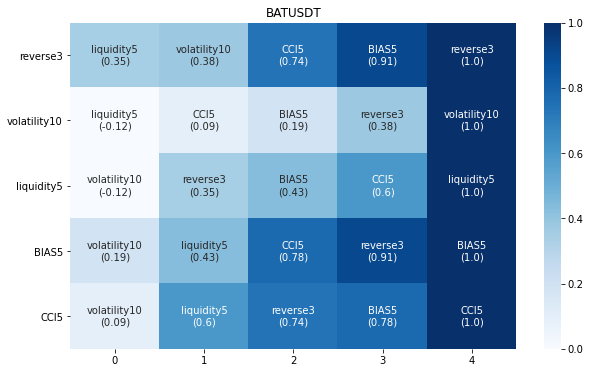

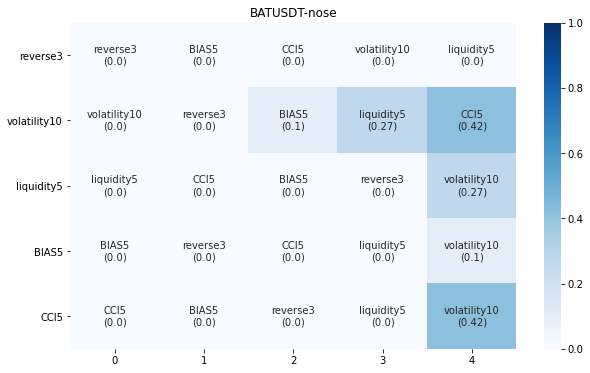

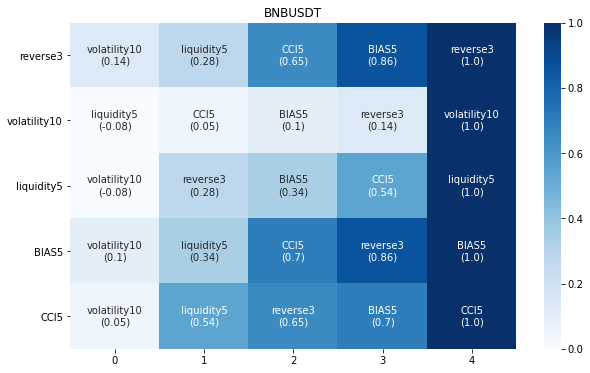

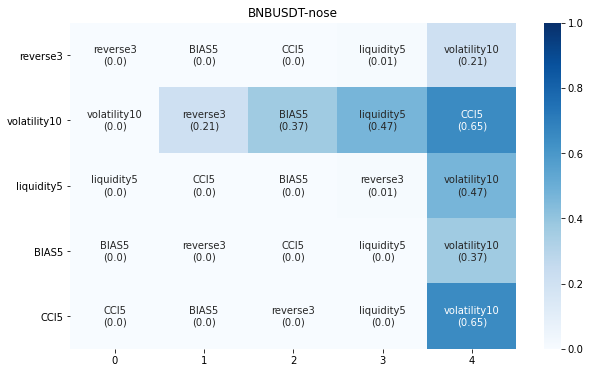

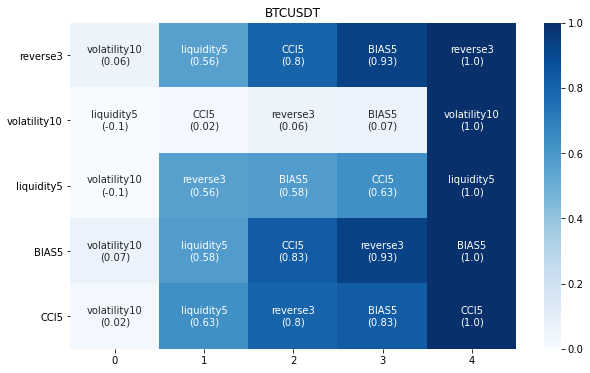

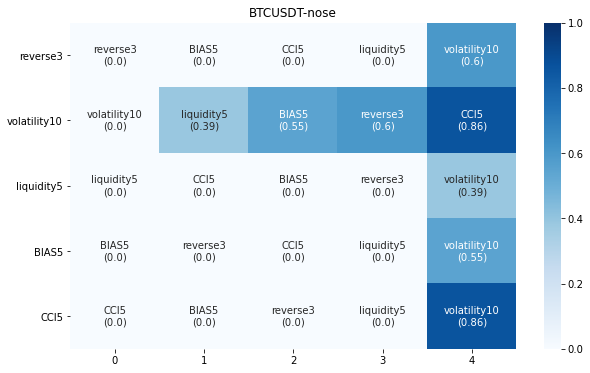

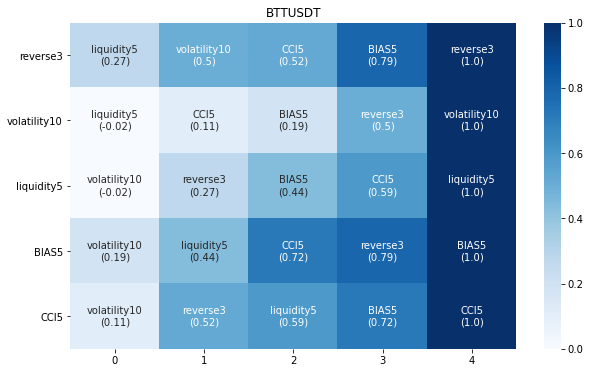

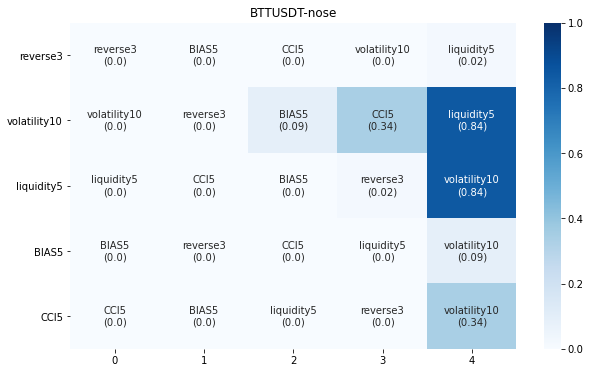

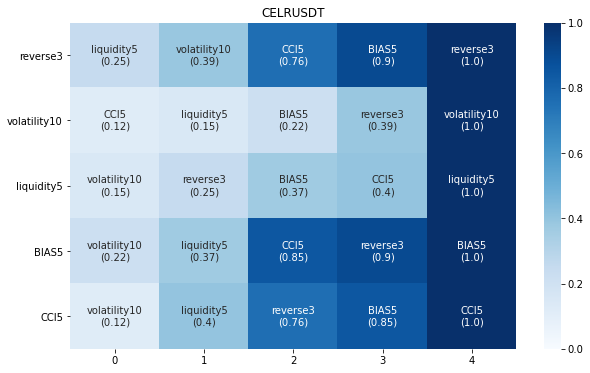

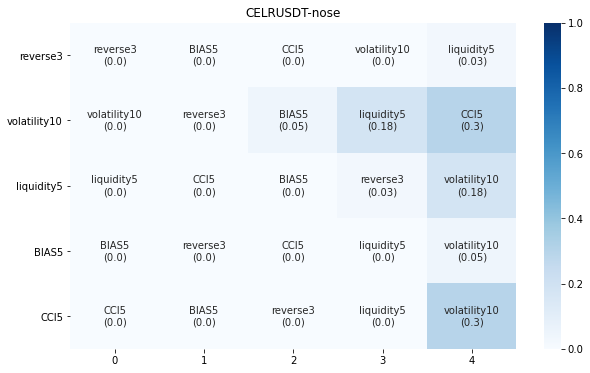

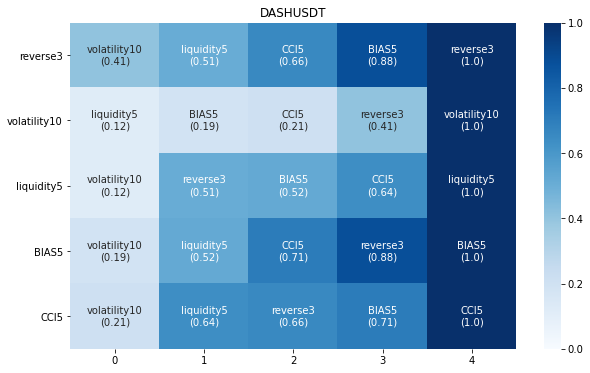

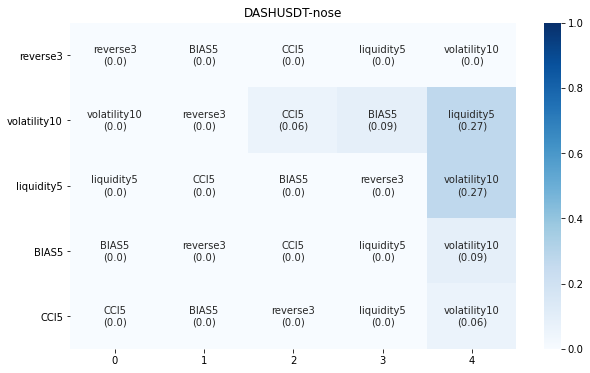

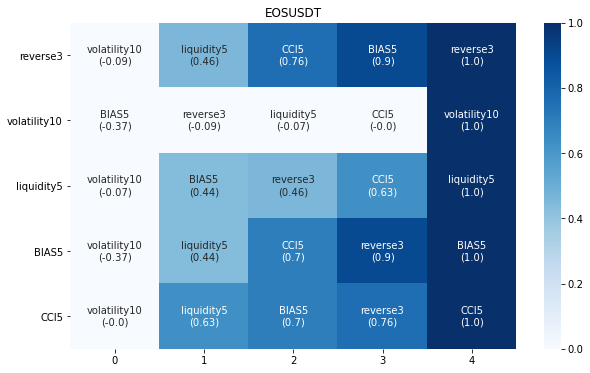

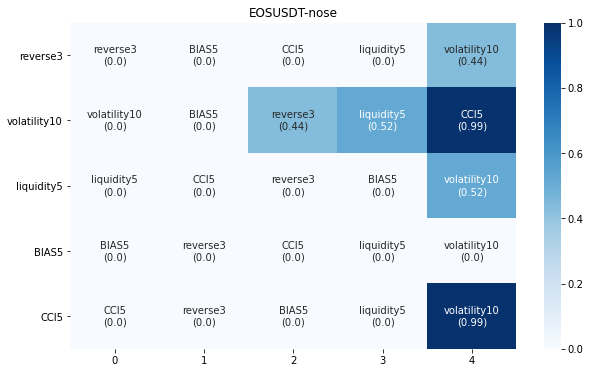

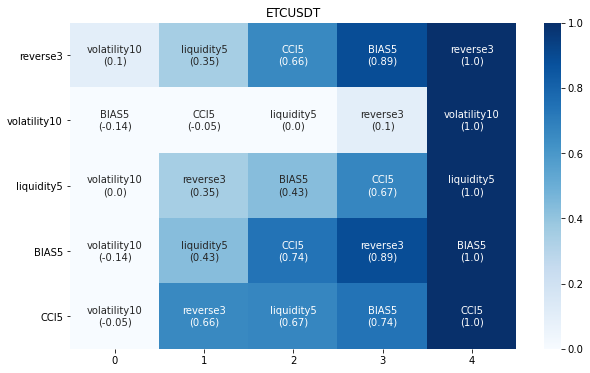

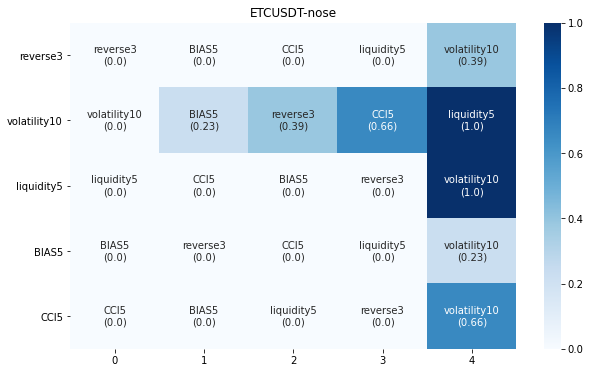

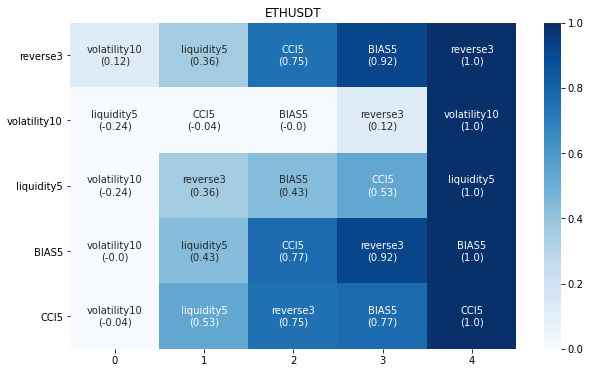

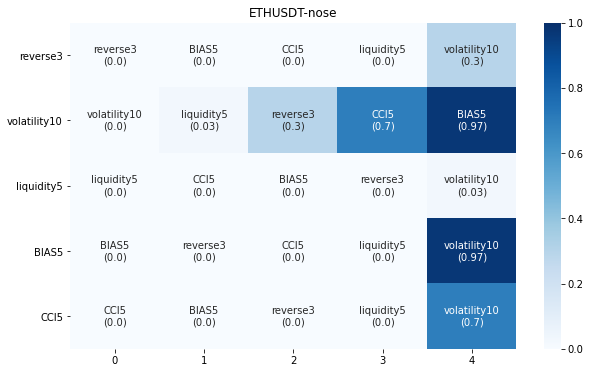

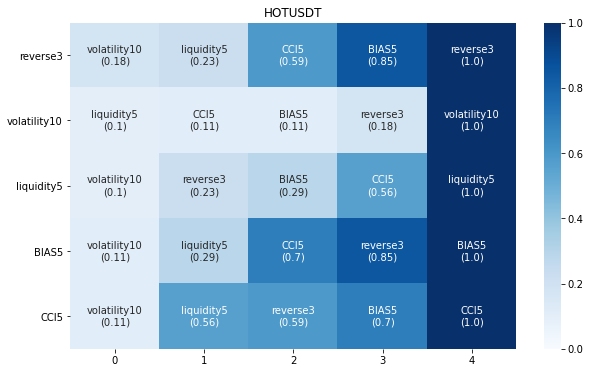

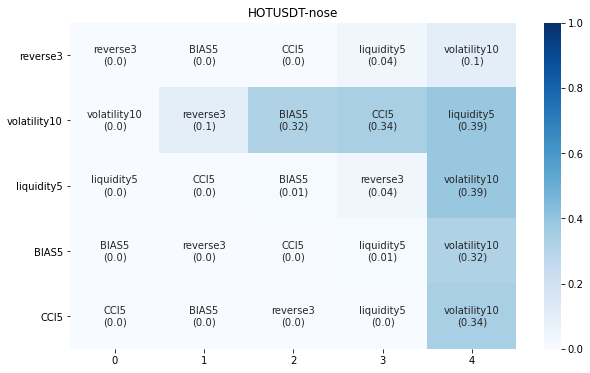

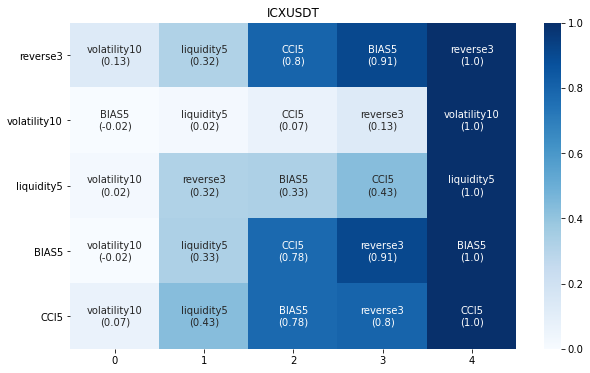

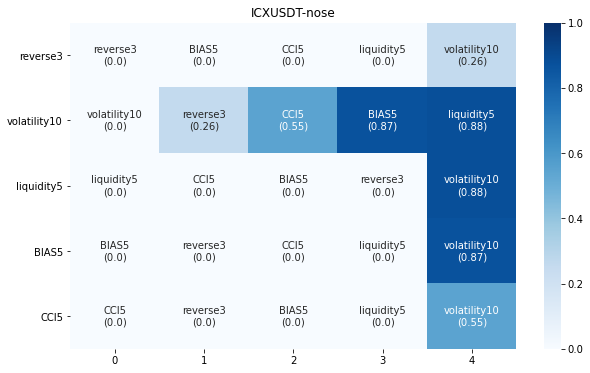

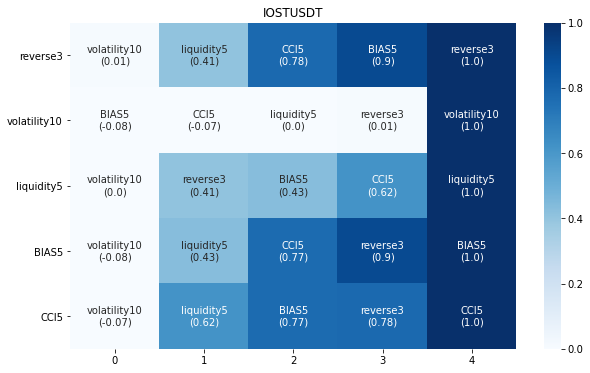

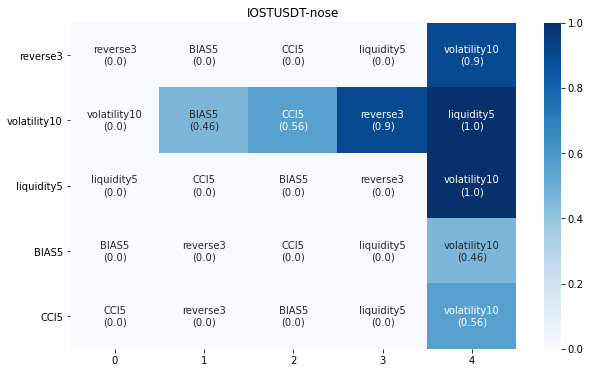

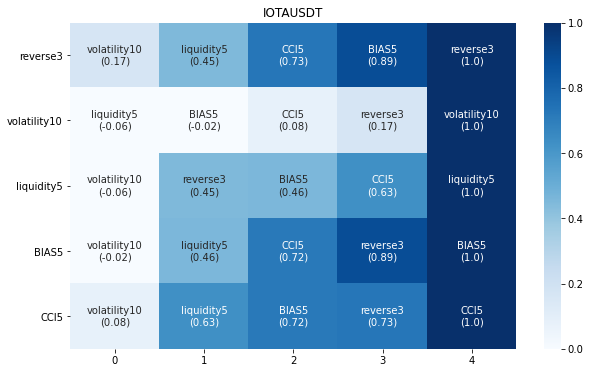

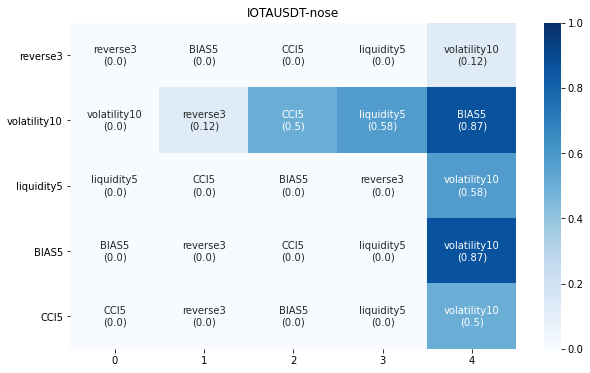

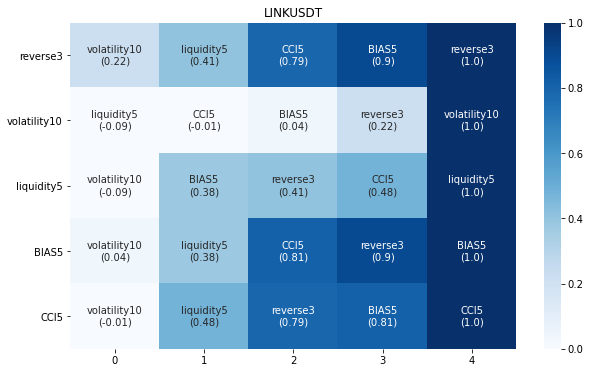

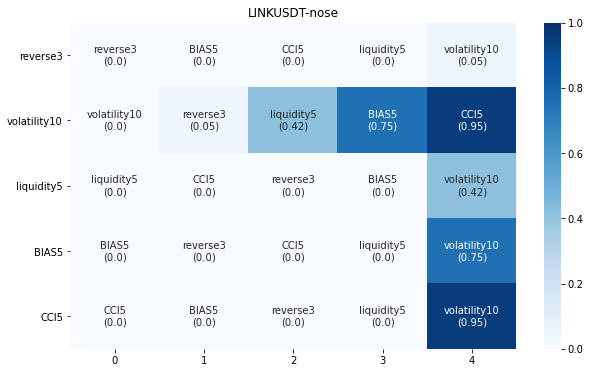

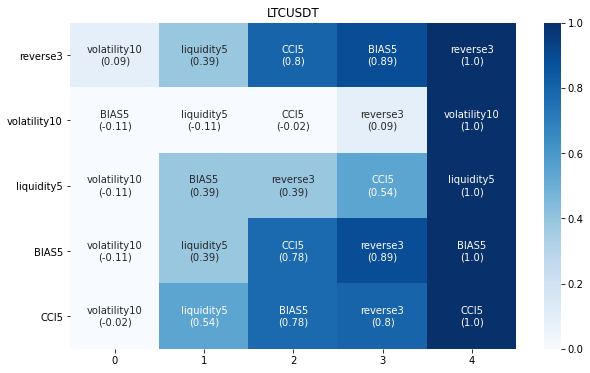

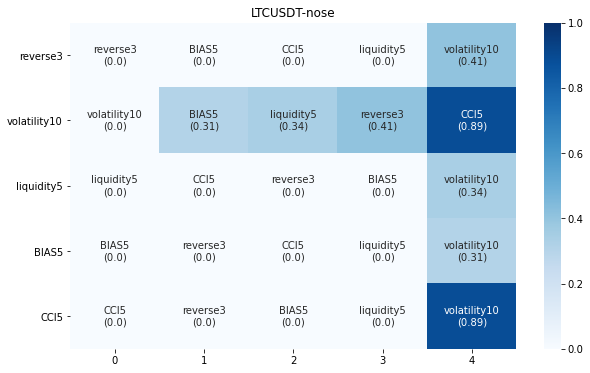

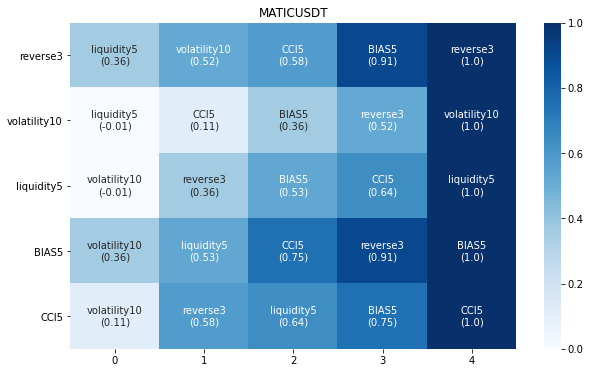

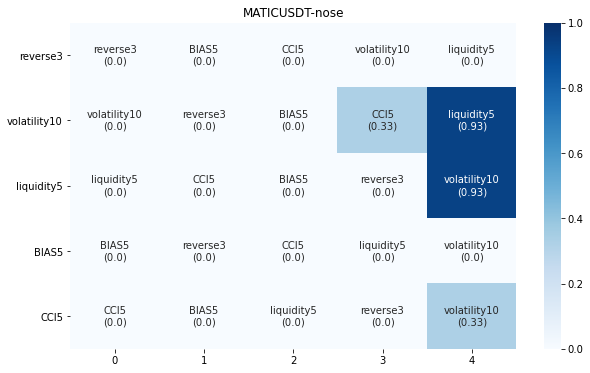

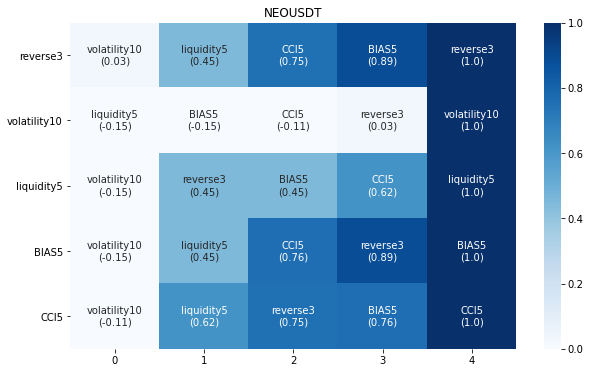

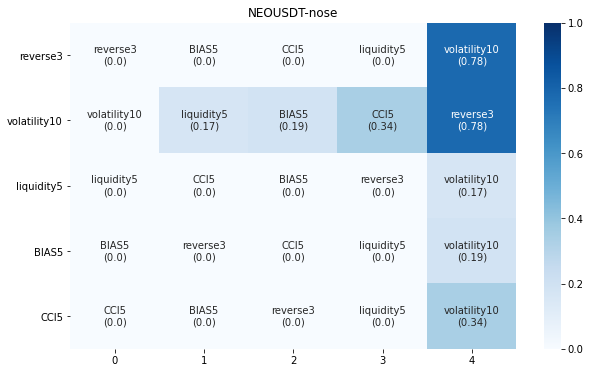

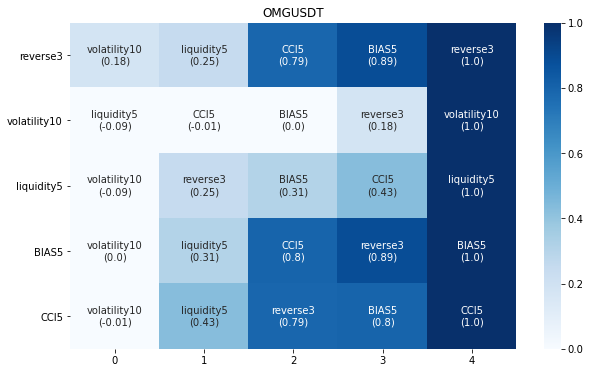

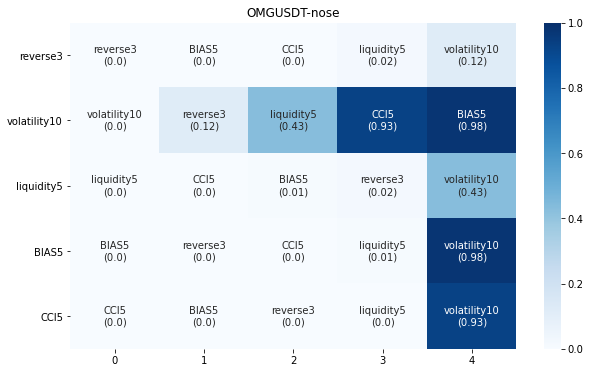

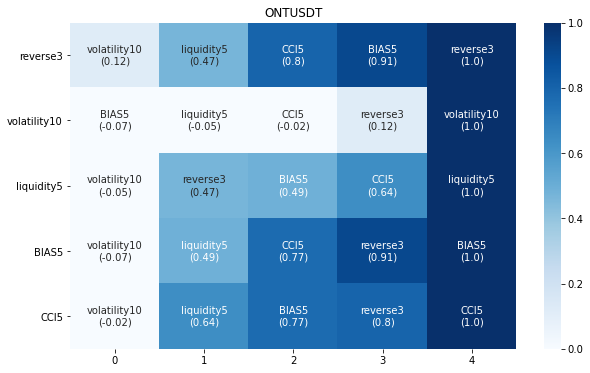

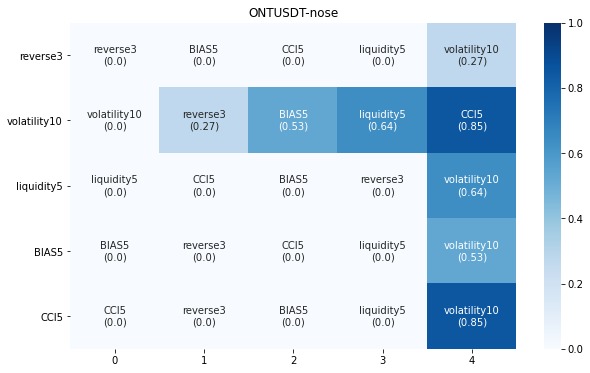

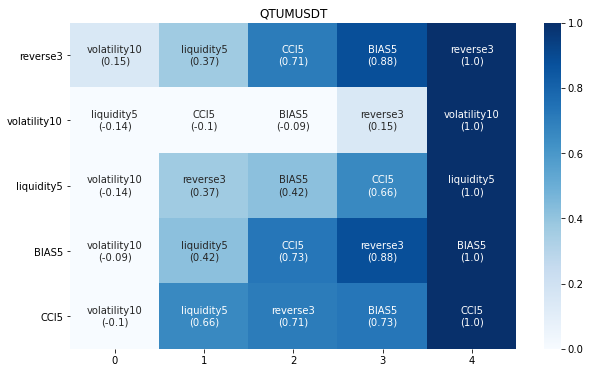

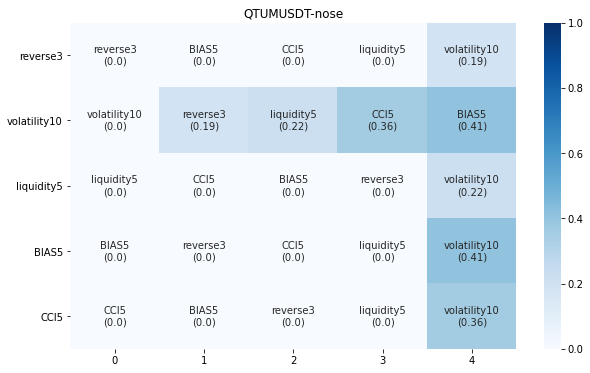

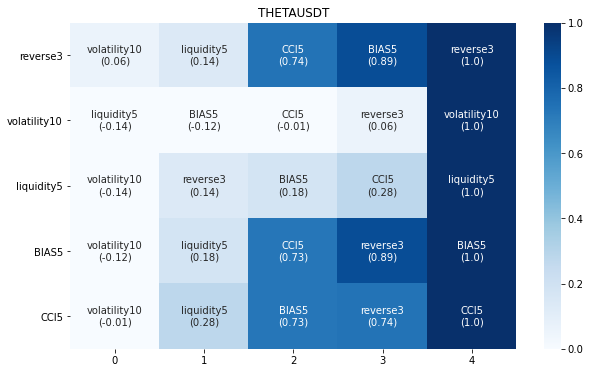

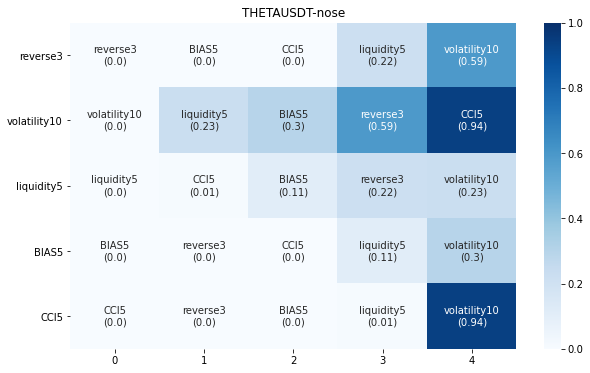

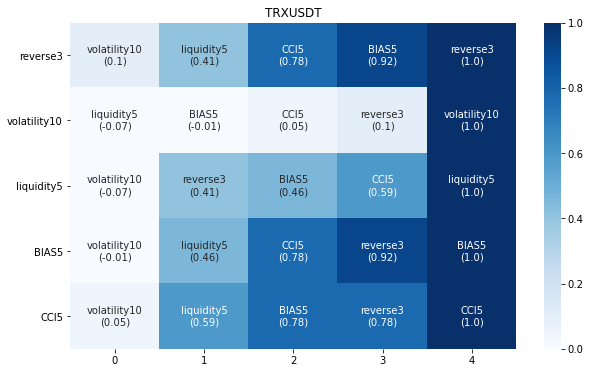

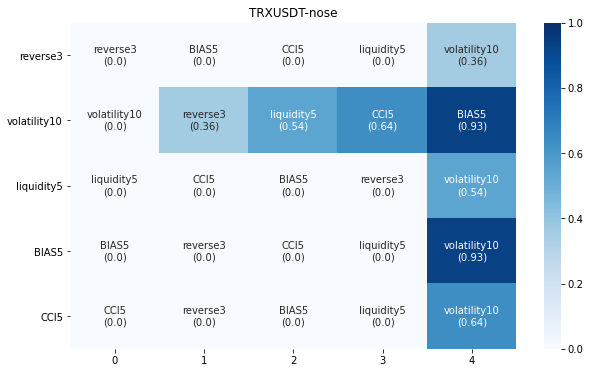

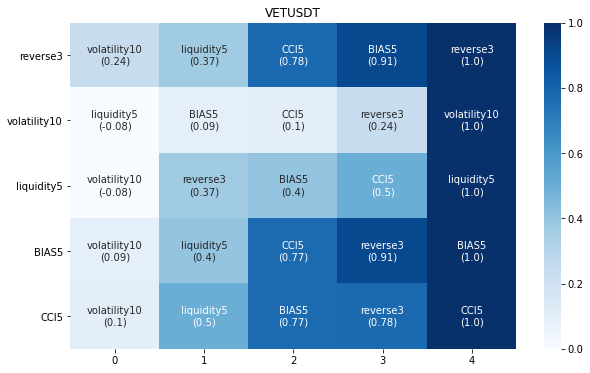

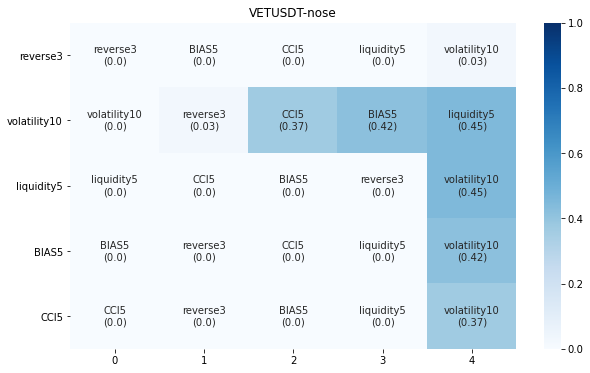

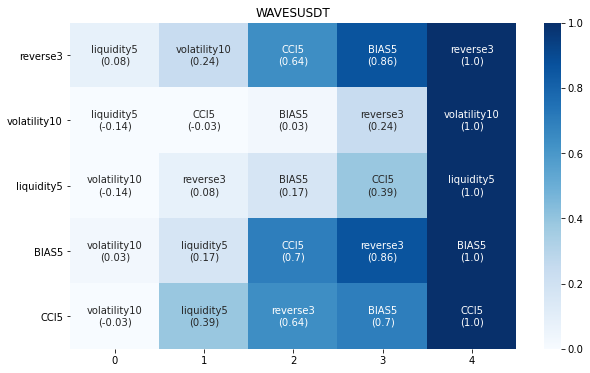

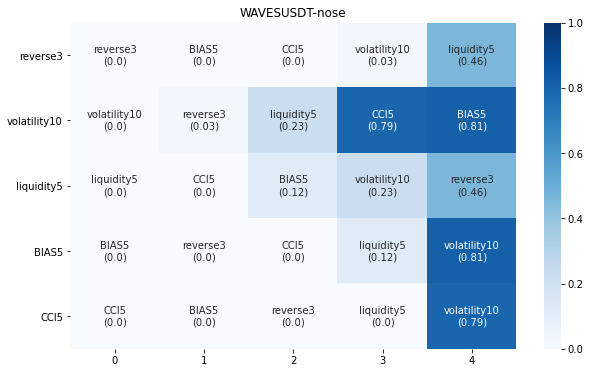

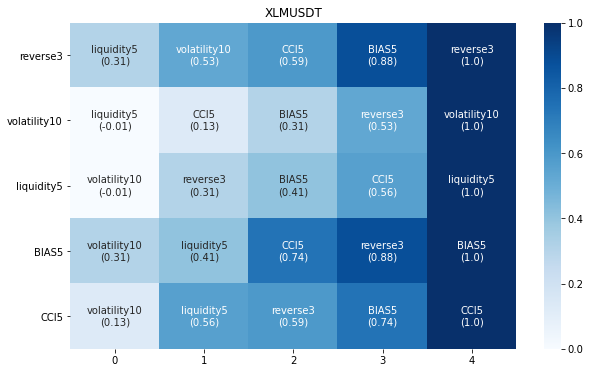

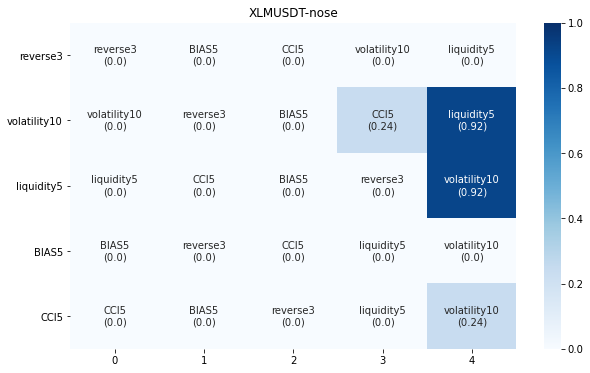

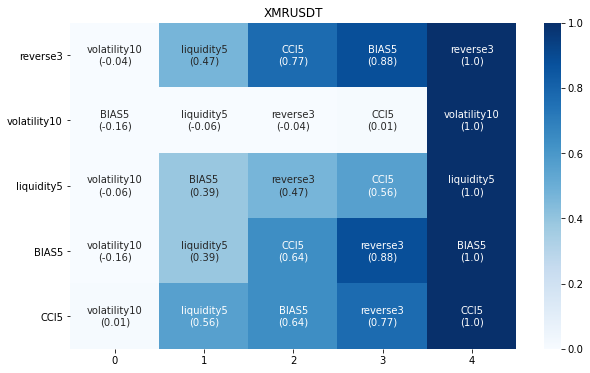

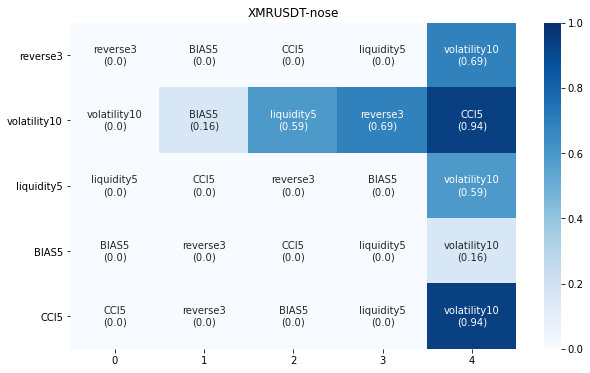

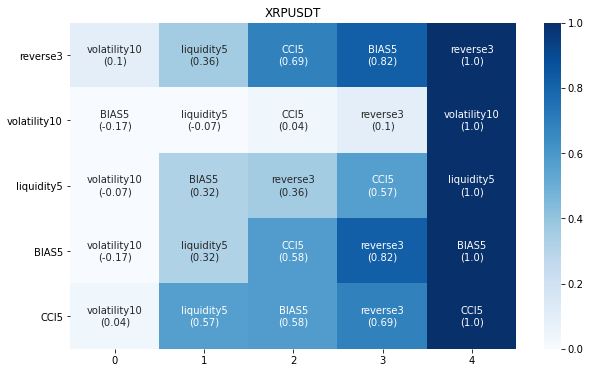

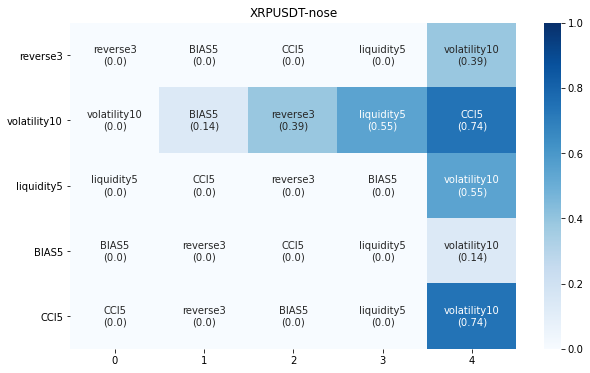

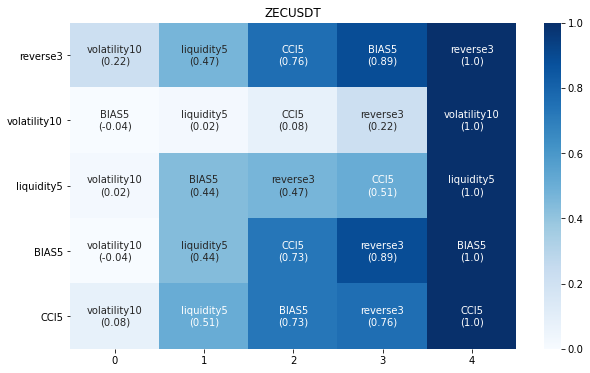

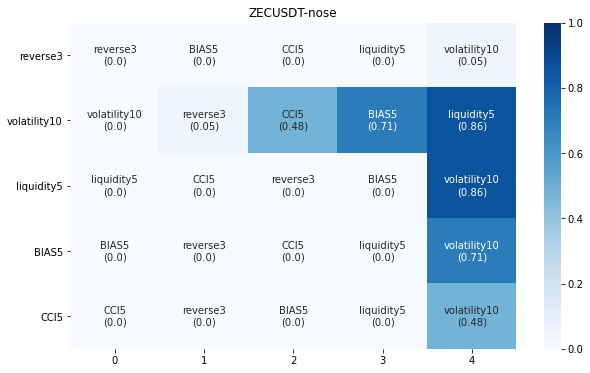

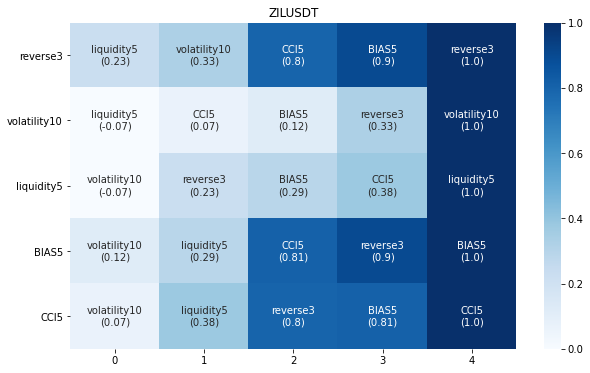

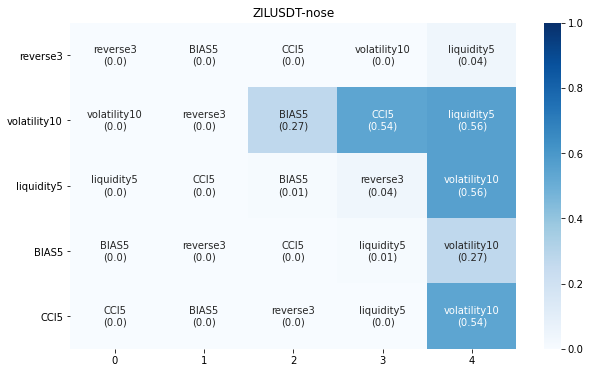

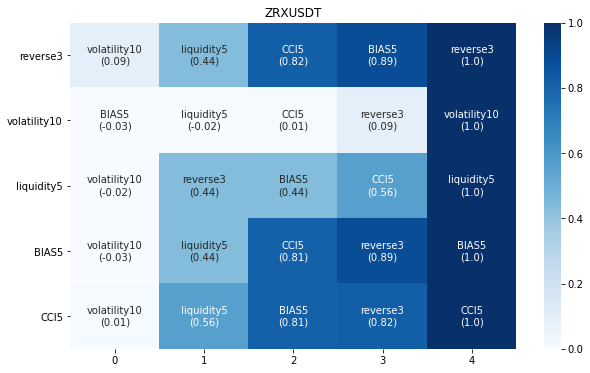

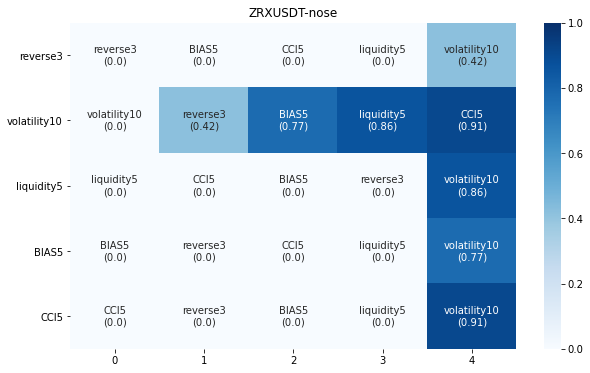

In [60]:
calculate_pearsonr('2020-01-01','2021-07-10','7D',datas,'1D',factor_list=factor_list,outdir=outdir,symbols=symbols,showplt=showplt,saveplt=saveplt)

#### 探索相关性

可见大部分因子之间的相关性都是比较低的。如果上述相关性检验中任意heatmap窗口中包含有显著 0.6<=|r| 的线性相关关系，我们可以认为这个窗口是显著的。

比如上述第一个图中的 P(bias5&reverse3) = 0.91 就说明两者存在比较高的相关性。 接着观察所有的图表，不难发现bias5 reverse3 cci5 都较为容易和其他因子发生相关性。

#### 估算或者计算相关发生概率

那么对于这三个因子，我们可以更多地考察在不同数据中，和其他因子之间的相关性（可以纯粹从统计显著性数量多少来看，可以取所有大于0.5的，统计每个因子和其他因子显著组合的实际数量，比如对于reverse3这个因子，我们统计所有出现大于0.5的数量，然后统计下一个，以此类推，来最终算出每一个因子和其他因子发生相关的具体概率）。

对于这个过程，我们也可以估算（因为只是决定剔除优先级，如果需要计算的比较多，大致估算也没有关系），估算后先剔除统计量较大的因子，然后重新检验，判断是否满足最后一步中显著窗口数量比率小于拒绝域的条件，直到接受该组合。比如我们在这一步中得出显著性的窗口量： bias5>reverse3>cci5 


#### 因子剔除

由此出发，最通常的方式是剔除其中的一个或者多个因子。比较可以发现，reverse3这个因子相较于bias5和其他的因子相关性程度更高。因此，如果剔除一个因子，那么我们需要剔除bias5。不过从实际情况出发，如果因子库足够丰富，我们有很多可以替换的选择，那应该尽可能避免绝大多数的显著性相关因子存在，所以可以将bias5和cci5这样在多个数据集上均出现相关性的因子一并剔除（这也取决于你使用的具体数据，如果在一个良好的数据集上模型中所有的因子彼此之间都不相关，那也就没有剔除的必要了）。并且，我们需要通过前面的单因子检验，同时作为参考考察因子质量。**如果是在框架中测试表现较好的单因子，那我们也可以在显著性的容忍范围上适当保留。**

#### 剔除后重新进行相关性检验

重复上述步骤，直到图中大部分的因子都处于彼此低相关。（如果要量化这个指标，0.6<=|r| 的相关性窗口占所有heatmap窗口的5%以内时为佳（可以参考统计学中t检验拒绝阈值作为我们接受模型中因子组合的相关性考量阈值）

假设我们的拒绝域就定为5%，那么无论剔除哪几个因子，最终进行相关性检验，所有显著窗口占总窗口的比率小于5%就是我们的目标。所以剔除过程中综合考量因子的质量或经济学意义也是很重要的。

